# Telecom Churn Case Study

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

import re
import random
import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib as mpt
import statsmodels as stm
import sklearn as skln

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(mpt.__version__))
print("seaborn : {0}".format(sns.__version__))
print("xgboost : {0}".format(xgb.__version__))
print("sklearn : {0}".format(skln.__version__))
print("statsmodel : {0}".format(stm.__version__))

python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
jupyter : 5.7.2
numpy : 1.26.4
pandas : 2.2.2
matplotlib : 3.9.2
seaborn : 0.13.2
xgboost : 2.1.3
sklearn : 1.5.1
statsmodel : 0.14.2


# Data Understanding

In [3]:
# Load the training dataset, testing data and data dictionary
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")
data_dict = pd.read_csv("others/data_dictionary.csv")

In [4]:
# Print the data dictionary
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [5]:
# Print the shape of training data
train_data.shape

(69999, 172)

In [6]:
# Print all columns in the training dataset
pd.set_option('display.max_info_columns', len(train_data.columns))
pd.set_option('display.max_columns', len(train_data.columns))
pd.set_option('display.max_rows', len(train_data.columns))

In [7]:
train_data.columns.tolist()

['id',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 

In [8]:
# Print the first 5 rows of training data
train_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [9]:
# Print information of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [10]:
# Describe data within the training data
train_data.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   67231.000000   67312.000000   66296.000000   67231.000000   
mean        9.765435       7.014568       7.004892      14.186457   
std        57.374429      55.960985      53.408135      73.469261   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67312.000000   66296.000000      67231.000000      67312.000000   
mean        9.842191       9.771783         46.904854         46.166503   
std        58.511894      64.618388        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      66296.000000      67231.000000      67312.000000      66296.000000   
mean          45.686109         93.238231         90.799240         91.121447   
std          153.716880        162.046699        153.852597        152.997805   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.610000          9.920000         10.090000          9.830000   
50%           11.740000         41.030000         40.170000         40.350000   
75%           39.895000        110.430000        107.540000        109.245000   
max        10752.560000       4696

In [11]:
# Drop columns where more than 50% of the rows are empty in training data
threshold = len(train_data) * 0.5
train_data = train_data.dropna(axis = 1, thresh = threshold)
train_data

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0          0        109             0.0             0.0             0.0   
1          1        109             0.0             0.0             0.0   
2          2        109             0.0             0.0             0.0   
3          3        109             0.0             0.0             0.0   
4          4        109             0.0             0.0             0.0   
...      ...        ...             ...             ...             ...   
69994  69994        109             0.0             0.0             0.0   
69995  69995        109             0.0             0.0             0.0   
69996  69996        109             0.0             0.0             0.0   
69997  69997        109             0.0             0.0             0.0   
69998  69998        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0                6/30/2014            7/31/2014            8/31/2014   31.277   
1                6/30/2014            7/31/2014            8/31/2014    0.000   
2                6/30/2014            7/31/2014            8/31/2014   60.806   
3                6/30/2014            7/31/2014            8/31/2014  156.362   
4                6/30/2014            7/31/2014            8/31/2014  240.708   
...                    ...                  ...                  ...      ...   
69994            6/30/2014            7/31/2014            8/31/2014   15.760   
69995            6/30/2014            7/31/2014            8/31/2014  160.083   
69996            6/30/2014            7/31/2014            8/31/2014  372.088   
69997            6/30/2014            7/31/2014            8/31/2014  238.575   
69998            6/30/2014            7/31/2014            8/31/2014  168.269   

        arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0       87.009    7.527        48.58       124.38         1.29         32.24   
1      122.787   42.953         0.00         0.00         0.00          0.00   
2      103.176    0.000         0.53        15.93         0.00         53.99   
3      205.260  111.095         7.26        16.01         0.00         68.76   
4      128.191  101.565        21.28         4.83         6.13         56.99   
...        ...      ...          ...          ...          ...           ...   
69994  410.924  329.136         0.00         7.36        10.93          0.00   
69995  289.129  265.772       116.54       196.46       232.63         49.53   
69996  258.374  279.782        77.13        68.44        78.44        335.54   
69997  245.414  145.062        14.01         7.64         6.71         30.34   
69998   42.815  167.961         0.00         0.00         0.00          0.00   

       offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0             96.68          2.33           0.00            0.0   
1             25.99         30.89           0.00            0.0   
2             82.05          0.00           0.00            0.0   
3             78.48         50.23           0.00            0.0   
4             38.11          9.63          53.64            0.0   
...             ...           ...            ...            ...   
69994        488.46        381.64          14.96            0.0   
69995         96.28         48.06           0.00            0.0   
69996        227.94        263.84           0.00            0.0   
69997         16.68         12.56          25.06            0.0   
69998          0.00          0.00           0.00            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0                0.0           0.00            0.0           0.00   
1                0.0           0.00            0.0           0.00   
2                0.0           0.00            0.0           0.00   
3                0.0           0.00            0.0           1.63   
4                0.0     

In [12]:
# Drop rows where more than 50% of the columns are empty in training data
threshold = len(train_data.columns) * 0.5
train_data = train_data.dropna(axis = 0, ignore_index = True, thresh = threshold)
train_data

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0          0        109             0.0             0.0             0.0   
1          1        109             0.0             0.0             0.0   
2          2        109             0.0             0.0             0.0   
3          3        109             0.0             0.0             0.0   
4          4        109             0.0             0.0             0.0   
...      ...        ...             ...             ...             ...   
69236  69994        109             0.0             0.0             0.0   
69237  69995        109             0.0             0.0             0.0   
69238  69996        109             0.0             0.0             0.0   
69239  69997        109             0.0             0.0             0.0   
69240  69998        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0                6/30/2014            7/31/2014            8/31/2014   31.277   
1                6/30/2014            7/31/2014            8/31/2014    0.000   
2                6/30/2014            7/31/2014            8/31/2014   60.806   
3                6/30/2014            7/31/2014            8/31/2014  156.362   
4                6/30/2014            7/31/2014            8/31/2014  240.708   
...                    ...                  ...                  ...      ...   
69236            6/30/2014            7/31/2014            8/31/2014   15.760   
69237            6/30/2014            7/31/2014            8/31/2014  160.083   
69238            6/30/2014            7/31/2014            8/31/2014  372.088   
69239            6/30/2014            7/31/2014            8/31/2014  238.575   
69240            6/30/2014            7/31/2014            8/31/2014  168.269   

        arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0       87.009    7.527        48.58       124.38         1.29         32.24   
1      122.787   42.953         0.00         0.00         0.00          0.00   
2      103.176    0.000         0.53        15.93         0.00         53.99   
3      205.260  111.095         7.26        16.01         0.00         68.76   
4      128.191  101.565        21.28         4.83         6.13         56.99   
...        ...      ...          ...          ...          ...           ...   
69236  410.924  329.136         0.00         7.36        10.93          0.00   
69237  289.129  265.772       116.54       196.46       232.63         49.53   
69238  258.374  279.782        77.13        68.44        78.44        335.54   
69239  245.414  145.062        14.01         7.64         6.71         30.34   
69240   42.815  167.961         0.00         0.00         0.00          0.00   

       offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0             96.68          2.33           0.00            0.0   
1             25.99         30.89           0.00            0.0   
2             82.05          0.00           0.00            0.0   
3             78.48         50.23           0.00            0.0   
4             38.11          9.63          53.64            0.0   
...             ...           ...            ...            ...   
69236        488.46        381.64          14.96            0.0   
69237         96.28         48.06           0.00            0.0   
69238        227.94        263.84           0.00            0.0   
69239         16.68         12.56          25.06            0.0   
69240          0.00          0.00           0.00            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0                0.0           0.00            0.0           0.00   
1                0.0           0.00            0.0           0.00   
2                0.0           0.00            0.0           0.00   
3                0.0           0.00            0.0           1.63   
4                0.0     

In [13]:
# Find all the columns where the number of values in the column is singular
# These will not contribute towards model building
single_value_cols = set([col for col in train_data.columns if len(train_data[col].value_counts()) == 1])
print("Columns with only one value =", single_value_cols)
train_data = train_data.drop(single_value_cols, axis = 1)
train_data

Columns with only one value = {'last_date_of_month_7', 'circle_id', 'std_og_t2o_mou', 'std_ic_t2o_mou_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'loc_og_t2o_mou', 'std_og_t2c_mou_7', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_8', 'last_date_of_month_6', 'std_og_t2c_mou_8', 'loc_ic_t2o_mou'}


id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
0             1.29         32.24         96.68          2.33           0.00   
1             0.00          0.00         25.99         30.89           0.00   
2             0.00         53.99         82.05          0.00           0.00   
3             0.00         68.76         78.48         50.23           0.00   
4             6.13         56.99         38.11          9.63          53.64   
...            ...           ...           ...           ...            ...   
69236        10.93          0.00        488.46        381.64          14.96   
69237       232.63         49.53         96.28         48.06           0.00   
69238        78.44        335.54        227.94        263.84           0.00   
69239         6.71         30.34         16.68         12.56          25.06   
69240         0.00          0.00          0.00          0.00           0.00   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
0                0.0            0.0           0.00            0.0   
1                0.0            0.0           0.00            0.0   
2                0.0            0.0           0.00            0.0   
3                0.0            0.0           0.00            0.0   
4                0.0            0.0          15.73            0.0   
...              ...            ...            ...            ...   
69236            0.0            0.0           0.00            0.0   
69237            0.0            0.0           0.00            0.0   
69238            0.0            0.0           0.00            0.0   
69239            0.0            0.0           4.58            0.0   
69240            0.0            0.0           0.00            0.0   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
0               0.00              2.23              0.00              0.28   
1               0.00              0.00              0.00              0.00   
2               0.00              0.53             12.98              0.00   
3               1.63              6.99              3.94              0.00   
4               0.00             10.16              4.83              6.13   
...              ...               ...               ...               ...   
69236           0.00              0.00              2.44              7.19   
69237           0.00              7.18             30.11              9.06   
69238           0.00             77.13             44.28             78.44   
69239           0.00             10.88              7.64              6.71   
69240           0.00              0.00              0.00              0.00   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
0                  5.29             16.04              2.33              0.00   
1                  0.00              0.00              0.00              0.00   
2                 24.11              0.00              0.00              0.00   
3                 37.91             44.89             23.63              0.00   
4                 36.74             19.88              4.61  

In [14]:
# Remove columns for T2T, T2M etc for minutes of usage as the total value is part of other columns and will be more relevant
operator_mobile = [col for col in list(train_data.columns) if re.search('t2t_mou', col)]
operator_fixed = [col for col in list(train_data.columns) if re.search('t2f_mou', col)]
operator_call_center = [col for col in list(train_data.columns) if re.search('t2c_mou', col)]
operator_other_mobile = [col for col in list(train_data.columns) if re.search('t2m_mou', col)]
operator_other_fixed = [col for col in list(train_data.columns) if re.search('t2o_mou', col)]
roaming = [col for col in list(train_data.columns) if re.search('roam', col)]

removal_columns = [*operator_mobile, *operator_fixed, *operator_call_center, *operator_other_mobile, *operator_other_fixed, *roaming]
train_data = train_data.drop(removal_columns, axis = 1)
train_data

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  \
0             1.29         32.24         96.68          2.33          7.53   
1             0.00          0.00         25.99         30.89          0.00   
2             0.00         53.99         82.05          0.00         24.64   
3             0.00         68.76         78.48         50.23         44.91   
4             6.13         56.99         38.11          9.63         58.91   
...            ...           ...           ...           ...           ...   
69236        10.93          0.00        488.46        381.64          0.00   
69237       232.63         49.53         96.28         48.06         46.73   
69238        78.44        335.54        227.94        263.84        362.91   
69239         6.71         30.34         16.68         12.56         23.33   
69240         0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0             16.04          2.61         65.09        204.99          1.01   
1              0.00          0.00          0.00          0.00          0.00   
2             12.98          0.00         28.94         84.99          0.00   
3             48.84         23.63         16.16         37.99          4.60   
4             25.94         15.76          4.35          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         63.09         96.86          0.00        419.53        293.88   
69237        103.96         56.41        119.34        184.76        224.09   
69238        268.13        342.29          0.00         24.16          0.00   
69239         15.76         18.43         16.45          8.56          0.85   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0              0.00           0.0           0.0          8.20          0.63   
1              0.00           0.0           0.0          0.00         30.73   
2              0.00           0.0           0.0          2.89          1.38   
3              0.00           0.0           0.0         14.95          9.13   
4              0.00           0.0           0.0          0.00         17.00   
...             ...           ...           ...           ...           ...   
69236          0.00           0.0           0.0          0.00         14.05   
69237          0.00           0.0           0.0          0.13          4.01   
69238          0.21           0.0           0.0         49.54          4.10   
69239          0.00           0.0           0.0          0.00          0.00   
69240          0.00           0.0           0.0          0.00          0.00   

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0              0.00         0.38          0.0          0.0           81.21   
1             31.66         0.00          0.0          0.0            0.00   
2              0.00         0.00          0.0          0.0           56.49   
3             25.61         0.00  

In [15]:
# Fill data as 0.0 for customers which have the ARPU (Avg revenue per user) as less than 0 for the same month
def fill_data_for_zero_revenue_customers(data):
    
    impute_columns = ['onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 
                  'loc_ic_mou', 'std_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others']
    suffixes = ['_6', '_7', '_8']
    
    for impute_column in impute_columns:
        for suffix in suffixes:
            
            column = impute_column + suffix
            filtered_data = data[data[column].isna()]
            
            filtered_data = filtered_data[filtered_data['arpu' + suffix] <= 0]
            data.loc[filtered_data.index, column] = 0

    return data
    
fill_data_for_zero_revenue_customers(train_data)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  \
0             1.29         32.24         96.68          2.33          7.53   
1             0.00          0.00         25.99         30.89          0.00   
2             0.00         53.99         82.05          0.00         24.64   
3             0.00         68.76         78.48         50.23         44.91   
4             6.13         56.99         38.11          9.63         58.91   
...            ...           ...           ...           ...           ...   
69236        10.93          0.00        488.46        381.64          0.00   
69237       232.63         49.53         96.28         48.06         46.73   
69238        78.44        335.54        227.94        263.84        362.91   
69239         6.71         30.34         16.68         12.56         23.33   
69240         0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0             16.04          2.61         65.09        204.99          1.01   
1              0.00          0.00          0.00          0.00          0.00   
2             12.98          0.00         28.94         84.99          0.00   
3             48.84         23.63         16.16         37.99          4.60   
4             25.94         15.76          4.35          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         63.09         96.86          0.00        419.53        293.88   
69237        103.96         56.41        119.34        184.76        224.09   
69238        268.13        342.29          0.00         24.16          0.00   
69239         15.76         18.43         16.45          8.56          0.85   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0              0.00           0.0           0.0          8.20          0.63   
1              0.00           0.0           0.0          0.00         30.73   
2              0.00           0.0           0.0          2.89          1.38   
3              0.00           0.0           0.0         14.95          9.13   
4              0.00           0.0           0.0          0.00         17.00   
...             ...           ...           ...           ...           ...   
69236          0.00           0.0           0.0          0.00         14.05   
69237          0.00           0.0           0.0          0.13          4.01   
69238          0.21           0.0           0.0         49.54          4.10   
69239          0.00           0.0           0.0          0.00          0.00   
69240          0.00           0.0           0.0          0.00          0.00   

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0              0.00         0.38          0.0          0.0           81.21   
1             31.66         0.00          0.0          0.0            0.00   
2              0.00         0.00          0.0          0.0           56.49   
3             25.61         0.00  

In [16]:
# Fill data as 0.0 for outgoing/incoming call types where customers have total outgoing/incoming calls as 0 in the training dataset
def fill_data_for_og_ic_calls(data):
    
    impute_columns = {
        'loc_og_mou': 'total_og_mou',
        'std_og_mou': 'total_og_mou',
        'isd_og_mou': 'total_og_mou',
        'spl_og_mou': 'total_og_mou',
        'og_others': 'total_og_mou',
        'loc_ic_mou': 'total_ic_mou',
        'std_ic_mou': 'total_ic_mou',
        'isd_ic_mou': 'total_ic_mou',
        'spl_ic_mou': 'total_ic_mou',
        'ic_others': 'total_ic_mou'
    }
    suffixes = ['_6', '_7', '_8']
    
    for impute_column in impute_columns:
        for suffix in suffixes:
            
            column = impute_column + suffix
            total = impute_columns[impute_column] + suffix
            filtered_data = data[data[column].isna()]
            
            total_filtered_data = filtered_data[filtered_data[total] == 0]
            data.loc[total_filtered_data.index, column] = 0

    return data
    
fill_data_for_og_ic_calls(train_data)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  \
0             1.29         32.24         96.68          2.33          7.53   
1             0.00          0.00         25.99         30.89          0.00   
2             0.00         53.99         82.05          0.00         24.64   
3             0.00         68.76         78.48         50.23         44.91   
4             6.13         56.99         38.11          9.63         58.91   
...            ...           ...           ...           ...           ...   
69236        10.93          0.00        488.46        381.64          0.00   
69237       232.63         49.53         96.28         48.06         46.73   
69238        78.44        335.54        227.94        263.84        362.91   
69239         6.71         30.34         16.68         12.56         23.33   
69240         0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0             16.04          2.61         65.09        204.99          1.01   
1              0.00          0.00          0.00          0.00          0.00   
2             12.98          0.00         28.94         84.99          0.00   
3             48.84         23.63         16.16         37.99          4.60   
4             25.94         15.76          4.35          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         63.09         96.86          0.00        419.53        293.88   
69237        103.96         56.41        119.34        184.76        224.09   
69238        268.13        342.29          0.00         24.16          0.00   
69239         15.76         18.43         16.45          8.56          0.85   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0              0.00           0.0           0.0          8.20          0.63   
1              0.00           0.0           0.0          0.00         30.73   
2              0.00           0.0           0.0          2.89          1.38   
3              0.00           0.0           0.0         14.95          9.13   
4              0.00           0.0           0.0          0.00         17.00   
...             ...           ...           ...           ...           ...   
69236          0.00           0.0           0.0          0.00         14.05   
69237          0.00           0.0           0.0          0.13          4.01   
69238          0.21           0.0           0.0         49.54          4.10   
69239          0.00           0.0           0.0          0.00          0.00   
69240          0.00           0.0           0.0          0.00          0.00   

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0              0.00         0.38          0.0          0.0           81.21   
1             31.66         0.00          0.0          0.0            0.00   
2              0.00         0.00          0.0          0.0           56.49   
3             25.61         0.00  

In [17]:
# Fill data as 0.0 for network call types where customers have total calls as 0 in the training dataset
def fill_data_for_net_calls(data):

    impute_columns = ['onnet_mou', 'offnet_mou']
    suffixes = ['_6', '_7', '_8']

    for impute_column in impute_columns:
        for suffix in suffixes:
    
            column = impute_column + suffix
            filtered_data = data[data[column].isna()]
            
            total_filtered_data = filtered_data[(filtered_data['total_og_mou' + suffix] + filtered_data['total_ic_mou' + suffix]) == 0]
            data.loc[total_filtered_data.index, column] = 0

    return data

fill_data_for_net_calls(train_data)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  \
0             1.29         32.24         96.68          2.33          7.53   
1             0.00          0.00         25.99         30.89          0.00   
2             0.00         53.99         82.05          0.00         24.64   
3             0.00         68.76         78.48         50.23         44.91   
4             6.13         56.99         38.11          9.63         58.91   
...            ...           ...           ...           ...           ...   
69236        10.93          0.00        488.46        381.64          0.00   
69237       232.63         49.53         96.28         48.06         46.73   
69238        78.44        335.54        227.94        263.84        362.91   
69239         6.71         30.34         16.68         12.56         23.33   
69240         0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0             16.04          2.61         65.09        204.99          1.01   
1              0.00          0.00          0.00          0.00          0.00   
2             12.98          0.00         28.94         84.99          0.00   
3             48.84         23.63         16.16         37.99          4.60   
4             25.94         15.76          4.35          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         63.09         96.86          0.00        419.53        293.88   
69237        103.96         56.41        119.34        184.76        224.09   
69238        268.13        342.29          0.00         24.16          0.00   
69239         15.76         18.43         16.45          8.56          0.85   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0              0.00           0.0           0.0          8.20          0.63   
1              0.00           0.0           0.0          0.00         30.73   
2              0.00           0.0           0.0          2.89          1.38   
3              0.00           0.0           0.0         14.95          9.13   
4              0.00           0.0           0.0          0.00         17.00   
...             ...           ...           ...           ...           ...   
69236          0.00           0.0           0.0          0.00         14.05   
69237          0.00           0.0           0.0          0.13          4.01   
69238          0.21           0.0           0.0         49.54          4.10   
69239          0.00           0.0           0.0          0.00          0.00   
69240          0.00           0.0           0.0          0.00          0.00   

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0              0.00         0.38          0.0          0.0           81.21   
1             31.66         0.00          0.0          0.0            0.00   
2              0.00         0.00          0.0          0.0           56.49   
3             25.61         0.00  

In [18]:
# Create a singular function to fill all the data (by invoking corresponding functions) and return the modified dataset
def fill_data(data):
    data = fill_data_for_zero_revenue_customers(data)
    data = fill_data_for_og_ic_calls(data)
    data = fill_data_for_net_calls(data)
    return data

train_data = fill_data(train_data)
train_data

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
0          0   31.277   87.009    7.527        48.58       124.38   
1          1    0.000  122.787   42.953         0.00         0.00   
2          2   60.806  103.176    0.000         0.53        15.93   
3          3  156.362  205.260  111.095         7.26        16.01   
4          4  240.708  128.191  101.565        21.28         4.83   
...      ...      ...      ...      ...          ...          ...   
69236  69994   15.760  410.924  329.136         0.00         7.36   
69237  69995  160.083  289.129  265.772       116.54       196.46   
69238  69996  372.088  258.374  279.782        77.13        68.44   
69239  69997  238.575  245.414  145.062        14.01         7.64   
69240  69998  168.269   42.815  167.961         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  \
0             1.29         32.24         96.68          2.33          7.53   
1             0.00          0.00         25.99         30.89          0.00   
2             0.00         53.99         82.05          0.00         24.64   
3             0.00         68.76         78.48         50.23         44.91   
4             6.13         56.99         38.11          9.63         58.91   
...            ...           ...           ...           ...           ...   
69236        10.93          0.00        488.46        381.64          0.00   
69237       232.63         49.53         96.28         48.06         46.73   
69238        78.44        335.54        227.94        263.84        362.91   
69239         6.71         30.34         16.68         12.56         23.33   
69240         0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0             16.04          2.61         65.09        204.99          1.01   
1              0.00          0.00          0.00          0.00          0.00   
2             12.98          0.00         28.94         84.99          0.00   
3             48.84         23.63         16.16         37.99          4.60   
4             25.94         15.76          4.35          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         63.09         96.86          0.00        419.53        293.88   
69237        103.96         56.41        119.34        184.76        224.09   
69238        268.13        342.29          0.00         24.16          0.00   
69239         15.76         18.43         16.45          8.56          0.85   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0              0.00           0.0           0.0          8.20          0.63   
1              0.00           0.0           0.0          0.00         30.73   
2              0.00           0.0           0.0          2.89          1.38   
3              0.00           0.0           0.0         14.95          9.13   
4              0.00           0.0           0.0          0.00         17.00   
...             ...           ...           ...           ...           ...   
69236          0.00           0.0           0.0          0.00         14.05   
69237          0.00           0.0           0.0          0.13          4.01   
69238          0.21           0.0           0.0         49.54          4.10   
69239          0.00           0.0           0.0          0.00          0.00   
69240          0.00           0.0           0.0          0.00          0.00   

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0              0.00         0.38          0.0          0.0           81.21   
1             31.66         0.00          0.0          0.0            0.00   
2              0.00         0.00          0.0          0.0           56.49   
3             25.61         0.00  

In [19]:
# Drop id column from the data frame as it's not relevant for analysis
train_data = train_data.drop(["id"], axis = 1)
train_data

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0       31.277   87.009    7.527        48.58       124.38         1.29   
1        0.000  122.787   42.953         0.00         0.00         0.00   
2       60.806  103.176    0.000         0.53        15.93         0.00   
3      156.362  205.260  111.095         7.26        16.01         0.00   
4      240.708  128.191  101.565        21.28         4.83         6.13   
...        ...      ...      ...          ...          ...          ...   
69236   15.760  410.924  329.136         0.00         7.36        10.93   
69237  160.083  289.129  265.772       116.54       196.46       232.63   
69238  372.088  258.374  279.782        77.13        68.44        78.44   
69239  238.575  245.414  145.062        14.01         7.64         6.71   
69240  168.269   42.815  167.961         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  loc_og_mou_7  \
0             32.24         96.68          2.33          7.53         16.04   
1              0.00         25.99         30.89          0.00          0.00   
2             53.99         82.05          0.00         24.64         12.98   
3             68.76         78.48         50.23         44.91         48.84   
4             56.99         38.11          9.63         58.91         25.94   
...             ...           ...           ...           ...           ...   
69236          0.00        488.46        381.64          0.00         63.09   
69237         49.53         96.28         48.06         46.73        103.96   
69238        335.54        227.94        263.84        362.91        268.13   
69239         30.34         16.68         12.56         23.33         15.76   
69240          0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
0              2.61         65.09        204.99          1.01          0.00   
1              0.00          0.00          0.00          0.00          0.00   
2              0.00         28.94         84.99          0.00          0.00   
3             23.63         16.16         37.99          4.60          0.00   
4             15.76          4.35          0.00          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         96.86          0.00        419.53        293.88          0.00   
69237         56.41        119.34        184.76        224.09          0.00   
69238        342.29          0.00         24.16          0.00          0.21   
69239         18.43         16.45          8.56          0.85          0.00   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0               0.0           0.0          8.20          0.63          0.00   
1               0.0           0.0          0.00         30.73         31.66   
2               0.0           0.0          2.89          1.38          0.00   
3               0.0           0.0         14.95          9.13         25.61   
4               0.0           0.0          0.00         17.00          0.00   
...             ...           ...           ...           ...           ...   
69236           0.0           0.0          0.00         14.05          1.83   
69237           0.0           0.0          0.13          4.01          0.18   
69238           0.0           0.0         49.54          4.10          0.00   
69239           0.0           0.0          0.00          0.00          0.00   
69240           0.0           0.0          0.00          0.00          0.00   

       og_others_6  og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
0             0.38          0.0          0.0           81.21          221.68   
1             0.00          0.0          0.0            0.00           30.73   
2             0.00  

# Feature Engineering

In [20]:
# Convert datetime columns from string to datetime format for further processing
def convert_data_to_datetime(data):
    
    columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

    for column in columns:
        data[column] = data[column].replace(0, np.nan)
        data[column] = pd.to_datetime(data[column])

    return data

convert_data_to_datetime(train_data)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0       31.277   87.009    7.527        48.58       124.38         1.29   
1        0.000  122.787   42.953         0.00         0.00         0.00   
2       60.806  103.176    0.000         0.53        15.93         0.00   
3      156.362  205.260  111.095         7.26        16.01         0.00   
4      240.708  128.191  101.565        21.28         4.83         6.13   
...        ...      ...      ...          ...          ...          ...   
69236   15.760  410.924  329.136         0.00         7.36        10.93   
69237  160.083  289.129  265.772       116.54       196.46       232.63   
69238  372.088  258.374  279.782        77.13        68.44        78.44   
69239  238.575  245.414  145.062        14.01         7.64         6.71   
69240  168.269   42.815  167.961         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  loc_og_mou_7  \
0             32.24         96.68          2.33          7.53         16.04   
1              0.00         25.99         30.89          0.00          0.00   
2             53.99         82.05          0.00         24.64         12.98   
3             68.76         78.48         50.23         44.91         48.84   
4             56.99         38.11          9.63         58.91         25.94   
...             ...           ...           ...           ...           ...   
69236          0.00        488.46        381.64          0.00         63.09   
69237         49.53         96.28         48.06         46.73        103.96   
69238        335.54        227.94        263.84        362.91        268.13   
69239         30.34         16.68         12.56         23.33         15.76   
69240          0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
0              2.61         65.09        204.99          1.01          0.00   
1              0.00          0.00          0.00          0.00          0.00   
2              0.00         28.94         84.99          0.00          0.00   
3             23.63         16.16         37.99          4.60          0.00   
4             15.76          4.35          0.00          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         96.86          0.00        419.53        293.88          0.00   
69237         56.41        119.34        184.76        224.09          0.00   
69238        342.29          0.00         24.16          0.00          0.21   
69239         18.43         16.45          8.56          0.85          0.00   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0               0.0           0.0          8.20          0.63          0.00   
1               0.0           0.0          0.00         30.73         31.66   
2               0.0           0.0          2.89          1.38          0.00   
3               0.0           0.0         14.95          9.13         25.61   
4               0.0           0.0          0.00         17.00          0.00   
...             ...           ...           ...           ...           ...   
69236           0.0           0.0          0.00         14.05          1.83   
69237           0.0           0.0          0.13          4.01          0.18   
69238           0.0           0.0         49.54          4.10          0.00   
69239           0.0           0.0          0.00          0.00          0.00   
69240           0.0           0.0          0.00          0.00          0.00   

       og_others_6  og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
0             0.38          0.0          0.0           81.21          221.68   
1             0.00          0.0          0.0            0.00           30.73   
2             0.00  

In [21]:
# Find number of days since last recharge, for calculation assume period is starting on 31st May 2014 and 
# ending on 31st August 2014
start_date = datetime.datetime(2014, 5, 31)
end_date = datetime.datetime(2014, 8, 31)

def days_since_last_recharge(row):
    if row.date_of_last_rech_8 is not pd.NaT:
        return (end_date - row.date_of_last_rech_8).days
    elif row.date_of_last_rech_7 is not pd.NaT:
        return (end_date - row.date_of_last_rech_7).days
    elif row.date_of_last_rech_6 is not pd.NaT:
        return (end_date - row.date_of_last_rech_6).days
    else:
        return (end_date - start_date).days

def create_days_since_last_recharge(data):
    data['days_since_last_rech'] = data.apply(days_since_last_recharge, axis=1)
    return data

create_days_since_last_recharge(train_data)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0       31.277   87.009    7.527        48.58       124.38         1.29   
1        0.000  122.787   42.953         0.00         0.00         0.00   
2       60.806  103.176    0.000         0.53        15.93         0.00   
3      156.362  205.260  111.095         7.26        16.01         0.00   
4      240.708  128.191  101.565        21.28         4.83         6.13   
...        ...      ...      ...          ...          ...          ...   
69236   15.760  410.924  329.136         0.00         7.36        10.93   
69237  160.083  289.129  265.772       116.54       196.46       232.63   
69238  372.088  258.374  279.782        77.13        68.44        78.44   
69239  238.575  245.414  145.062        14.01         7.64         6.71   
69240  168.269   42.815  167.961         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  loc_og_mou_7  \
0             32.24         96.68          2.33          7.53         16.04   
1              0.00         25.99         30.89          0.00          0.00   
2             53.99         82.05          0.00         24.64         12.98   
3             68.76         78.48         50.23         44.91         48.84   
4             56.99         38.11          9.63         58.91         25.94   
...             ...           ...           ...           ...           ...   
69236          0.00        488.46        381.64          0.00         63.09   
69237         49.53         96.28         48.06         46.73        103.96   
69238        335.54        227.94        263.84        362.91        268.13   
69239         30.34         16.68         12.56         23.33         15.76   
69240          0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
0              2.61         65.09        204.99          1.01          0.00   
1              0.00          0.00          0.00          0.00          0.00   
2              0.00         28.94         84.99          0.00          0.00   
3             23.63         16.16         37.99          4.60          0.00   
4             15.76          4.35          0.00          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         96.86          0.00        419.53        293.88          0.00   
69237         56.41        119.34        184.76        224.09          0.00   
69238        342.29          0.00         24.16          0.00          0.21   
69239         18.43         16.45          8.56          0.85          0.00   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0               0.0           0.0          8.20          0.63          0.00   
1               0.0           0.0          0.00         30.73         31.66   
2               0.0           0.0          2.89          1.38          0.00   
3               0.0           0.0         14.95          9.13         25.61   
4               0.0           0.0          0.00         17.00          0.00   
...             ...           ...           ...           ...           ...   
69236           0.0           0.0          0.00         14.05          1.83   
69237           0.0           0.0          0.13          4.01          0.18   
69238           0.0           0.0         49.54          4.10          0.00   
69239           0.0           0.0          0.00          0.00          0.00   
69240           0.0           0.0          0.00          0.00          0.00   

       og_others_6  og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
0             0.38          0.0          0.0           81.21          221.68   
1             0.00          0.0          0.0            0.00           30.73   
2             0.00  

In [22]:
# Create columns for totals of various statistics list minutes of usage, average revenue etc
totals_column = lambda data, column: data[column + '_6'] + data[column + '_7'] + data[column + '_8']

# Create column for calculating change in statistics between June and August
change_column = lambda data, column: (data[column + '_8'] - data[column + '_6']) / 2

# Drop columns for which data has been generated
drop_column = lambda data, column: data.drop([column + '_6', column + '_7', column + '_8'], axis = 1)

def create_totals_change_column(data) :
    for column in ['arpu', 'onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 
                   'loc_ic_mou', 'std_ic_mou', 'isd_ic_mou', 'spl_ic_mou', 'ic_others', 'total_ic_mou', 'vol_2g_mb', 'vol_3g_mb',
                   'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'total_rech_num', 'total_rech_amt']:
        data[column + '_total'] = totals_column(data, column)
        data[column + '_change'] = change_column(data, column)

    for column in ['onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou',
                   'loc_ic_mou', 'std_ic_mou', 'isd_ic_mou', 'spl_ic_mou', 'ic_others', 'total_ic_mou', 'vol_2g_mb', 'vol_3g_mb', 
                   'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'total_rech_num', 'total_rech_amt']:
        data = drop_column(data, column)
    return data

create_totals_change_column(train_data)

arpu_6   arpu_7   arpu_8  max_rech_amt_6  max_rech_amt_7  \
0       31.277   87.009    7.527              65              65   
1        0.000  122.787   42.953               0             145   
2       60.806  103.176    0.000              70              70   
3      156.362  205.260  111.095             110             110   
4      240.708  128.191  101.565              50              41   
...        ...      ...      ...             ...             ...   
69236   15.760  410.924  329.136              50             110   
69237  160.083  289.129  265.772              90              44   
69238  372.088  258.374  279.782             279             250   
69239  238.575  245.414  145.062             200             252   
69240  168.269   42.815  167.961             198              50   

       max_rech_amt_8 date_of_last_rech_6 date_of_last_rech_7  \
0                  10          2014-06-22          2014-07-10   
1                  50          2014-06-12          2014-07-10   
2                   0          2014-06-11          2014-07-22   
3                  50          2014-06-15          2014-07-21   
4                  30          2014-06-25          2014-07-26   
...               ...                 ...                 ...   
69236             130          2014-06-18          2014-07-31   
69237              44          2014-06-28          2014-07-31   
69238             349          2014-06-25          2014-07-30   
69239             145          2014-06-29          2014-07-19   
69240             198          2014-06-19          2014-07-27   

      date_of_last_rech_8  last_day_rch_amt_6  last_day_rch_amt_7  \
0              2014-08-24                  65                  65   
1              2014-08-26                   0                   0   
2              2014-08-24                  70                  50   
3              2014-08-25                 110                 110   
4              2014-08-30                  25                  10   
...                   ...                 ...                 ...   
69236          2014-08-31                  50                  20   
69237          2014-08-27                  50                  30   
69238          2014-08-29                 279                 250   
69239          2014-08-26                   0                   0   
69240          2014-08-25                 198                   0   

       last_day_rch_amt_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0                       0  1958        0.00        0.00        0.00   
1                       0   710        0.00        0.00        0.00   
2                       0   882        0.00        0.00        0.00   
3                      50   982        0.00        0.00        0.00   
4                      30   647        0.00        0.00        0.00   
...                   ...   ...         ...         ...         ...   
69236                 130   221        0.00        0.00        0.00   
69237                  42   712        0.00        0.00        0.00   
69238                  48   879        0.00        0.00        0.00   
69239                   0   277      664.25     1402.96      990.97   
69240                   0  1876        0.00        0.00        0.00   

       churn_probability  days_since_last_rech  arpu_total  arpu_change  \
0                      0                     7     125.813     -11.8750   
1                      0                     5     165.740      21.4765   
2                      0                     7     163.982     -30.4030   
3                      0                     6     472.717     -22.6335   
4                      0                     1     470.464     -69.5715   
...                  ...                   ...         ...          ...   
69236                  0                     0     755.820     156.6880   
69237                  0                     4     714.984      52.8445   
69238                  0                     2     91

In [23]:
# Create aggregate statistics for VBC
def create_total_vbc_column(data):
    data['vbc_3g_total'] = data['jun_vbc_3g'] + data['jul_vbc_3g'] + data['aug_vbc_3g']
    data['vbc_3g_change'] = (data['aug_vbc_3g'] - data['jun_vbc_3g']) / 2
    data.drop(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis = 1)
    return data

create_total_vbc_column(train_data)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0       31.277   87.009    7.527        48.58       124.38         1.29   
1        0.000  122.787   42.953         0.00         0.00         0.00   
2       60.806  103.176    0.000         0.53        15.93         0.00   
3      156.362  205.260  111.095         7.26        16.01         0.00   
4      240.708  128.191  101.565        21.28         4.83         6.13   
...        ...      ...      ...          ...          ...          ...   
69236   15.760  410.924  329.136         0.00         7.36        10.93   
69237  160.083  289.129  265.772       116.54       196.46       232.63   
69238  372.088  258.374  279.782        77.13        68.44        78.44   
69239  238.575  245.414  145.062        14.01         7.64         6.71   
69240  168.269   42.815  167.961         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  loc_og_mou_6  loc_og_mou_7  \
0             32.24         96.68          2.33          7.53         16.04   
1              0.00         25.99         30.89          0.00          0.00   
2             53.99         82.05          0.00         24.64         12.98   
3             68.76         78.48         50.23         44.91         48.84   
4             56.99         38.11          9.63         58.91         25.94   
...             ...           ...           ...           ...           ...   
69236          0.00        488.46        381.64          0.00         63.09   
69237         49.53         96.28         48.06         46.73        103.96   
69238        335.54        227.94        263.84        362.91        268.13   
69239         30.34         16.68         12.56         23.33         15.76   
69240          0.00          0.00          0.00          0.00          0.00   

       loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
0              2.61         65.09        204.99          1.01          0.00   
1              0.00          0.00          0.00          0.00          0.00   
2              0.00         28.94         84.99          0.00          0.00   
3             23.63         16.16         37.99          4.60          0.00   
4             15.76          4.35          0.00          0.00          0.00   
...             ...           ...           ...           ...           ...   
69236         96.86          0.00        419.53        293.88          0.00   
69237         56.41        119.34        184.76        224.09          0.00   
69238        342.29          0.00         24.16          0.00          0.21   
69239         18.43         16.45          8.56          0.85          0.00   
69240          0.00          0.00          0.00          0.00          0.00   

       isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0               0.0           0.0          8.20          0.63          0.00   
1               0.0           0.0          0.00         30.73         31.66   
2               0.0           0.0          2.89          1.38          0.00   
3               0.0           0.0         14.95          9.13         25.61   
4               0.0           0.0          0.00         17.00          0.00   
...             ...           ...           ...           ...           ...   
69236           0.0           0.0          0.00         14.05          1.83   
69237           0.0           0.0          0.13          4.01          0.18   
69238           0.0           0.0         49.54          4.10          0.00   
69239           0.0           0.0          0.00          0.00          0.00   
69240           0.0           0.0          0.00          0.00          0.00   

       og_others_6  og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
0             0.38          0.0          0.0           81.21          221.68   
1             0.00          0.0          0.0            0.00           30.73   
2             0.00  

In [24]:
# Creare a singular function to modify existing columns or create new columns and return the modified dataset
def create_and_modify_columns(data):
    data = convert_data_to_datetime(data)
    data = create_days_since_last_recharge(data)
    data = create_totals_change_column(data)
    data = create_total_vbc_column(data)
    return data

train_data = create_and_modify_columns(train_data)
train_data

arpu_6   arpu_7   arpu_8  max_rech_amt_6  max_rech_amt_7  \
0       31.277   87.009    7.527              65              65   
1        0.000  122.787   42.953               0             145   
2       60.806  103.176    0.000              70              70   
3      156.362  205.260  111.095             110             110   
4      240.708  128.191  101.565              50              41   
...        ...      ...      ...             ...             ...   
69236   15.760  410.924  329.136              50             110   
69237  160.083  289.129  265.772              90              44   
69238  372.088  258.374  279.782             279             250   
69239  238.575  245.414  145.062             200             252   
69240  168.269   42.815  167.961             198              50   

       max_rech_amt_8 date_of_last_rech_6 date_of_last_rech_7  \
0                  10          2014-06-22          2014-07-10   
1                  50          2014-06-12          2014-07-10   
2                   0          2014-06-11          2014-07-22   
3                  50          2014-06-15          2014-07-21   
4                  30          2014-06-25          2014-07-26   
...               ...                 ...                 ...   
69236             130          2014-06-18          2014-07-31   
69237              44          2014-06-28          2014-07-31   
69238             349          2014-06-25          2014-07-30   
69239             145          2014-06-29          2014-07-19   
69240             198          2014-06-19          2014-07-27   

      date_of_last_rech_8  last_day_rch_amt_6  last_day_rch_amt_7  \
0              2014-08-24                  65                  65   
1              2014-08-26                   0                   0   
2              2014-08-24                  70                  50   
3              2014-08-25                 110                 110   
4              2014-08-30                  25                  10   
...                   ...                 ...                 ...   
69236          2014-08-31                  50                  20   
69237          2014-08-27                  50                  30   
69238          2014-08-29                 279                 250   
69239          2014-08-26                   0                   0   
69240          2014-08-25                 198                   0   

       last_day_rch_amt_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0                       0  1958        0.00        0.00        0.00   
1                       0   710        0.00        0.00        0.00   
2                       0   882        0.00        0.00        0.00   
3                      50   982        0.00        0.00        0.00   
4                      30   647        0.00        0.00        0.00   
...                   ...   ...         ...         ...         ...   
69236                 130   221        0.00        0.00        0.00   
69237                  42   712        0.00        0.00        0.00   
69238                  48   879        0.00        0.00        0.00   
69239                   0   277      664.25     1402.96      990.97   
69240                   0  1876        0.00        0.00        0.00   

       churn_probability  days_since_last_rech  arpu_total  arpu_change  \
0                      0                     7     125.813     -11.8750   
1                      0                     5     165.740      21.4765   
2                      0                     7     163.982     -30.4030   
3                      0                     6     472.717     -22.6335   
4                      0                     1     470.464     -69.5715   
...                  ...                   ...         ...          ...   
69236                  0                     0     755.820     156.6880   
69237                  0                     4     714.984      52.8445   
69238                  0                     2     91

# Data Visualisation (EDA)

In [25]:
# Define a list of colors and palettes, and define function to choose randomly
color_list = ["seagreen", "red", "orange", "blue", "pink", "green", "brown", "darkblue", "purple", "grey"]
palette_list = ["Set1", "Set2", "Set3", "Paired", "muted", "deep", "pastel", "hls", "husl"]
cmap_list = ["Spectral", "Greens", "flare_r"]

random_color = lambda: random.choice(color_list)
random_palette = lambda: random.choice(palette_list)
random_cmap = lambda: random.choice(cmap_list)

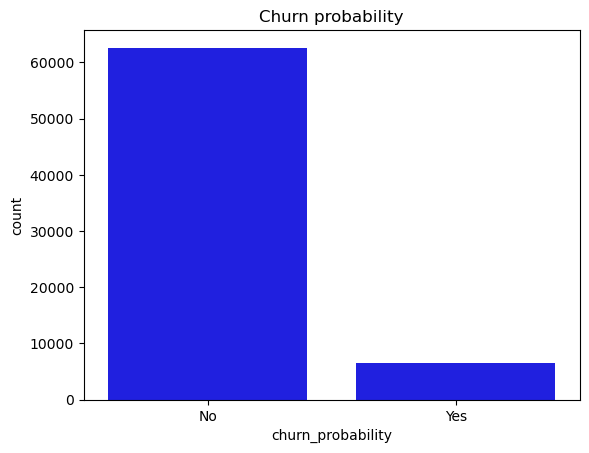

In [26]:
# Plot the key column (churn probability) as count plot
sns.countplot(x = train_data["churn_probability"], color = random_color())
plt.xticks([0, 1], ["No", "Yes"])
plt.title("Churn probability")
plt.show()

In [27]:
# Define a function to draw hist plots with the given features and choosing colors randomly
def draw_dis_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        plot = sns.histplot(data = data, 
                            x = features[i]["x"],
                            hue = features[i]["hue"],
                            palette = random_palette(),
                            log_scale = True,
                            multiple = "stack"
                            )
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

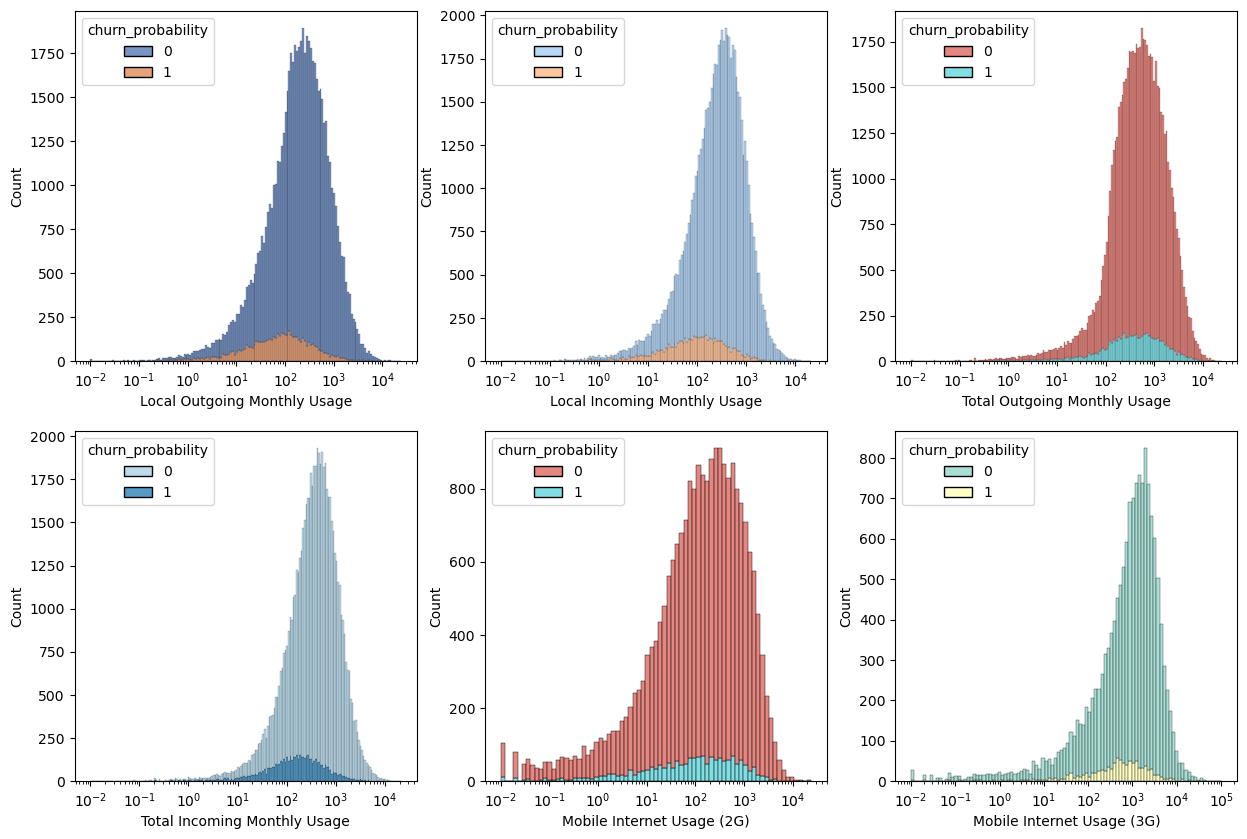

In [28]:
# Draw displots for features representing total usage for outgoing/incoming calls as log plots
features = [
    {
        "x": "loc_og_mou_total",
        "hue": "churn_probability",
        "title": "Local Outgoing Monthly Usage"
    },
    {
        "x": "loc_ic_mou_total",
        "hue": "churn_probability",
        "title": "Local Incoming Monthly Usage"
    },
    {
        "x": "total_og_mou_total",
        "hue": "churn_probability",
        "title": "Total Outgoing Monthly Usage"
    },
    {
        "x": "total_ic_mou_total",
        "hue": "churn_probability",
        "title": "Total Incoming Monthly Usage"
    },
    {
        "x": "vol_2g_mb_total",
        "hue": "churn_probability",
        "title": "Mobile Internet Usage (2G)"
    },
    {
        "x": "vol_3g_mb_total",
        "hue": "churn_probability",
        "title": "Mobile Internet Usage (3G)"
    }
]
draw_dis_plots([2, 3], train_data, features)

In [29]:
# Define a function to draw hist plots with the given features and choosing colors randomly using x and hue
def draw_hist_plots_with_hue(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        plot = sns.histplot(data = data, 
                            x = features[i]["x"],
                            hue = features[i]["hue"],
                            palette = random_palette(), 
                            bins = 10,
                            multiple = "fill")
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

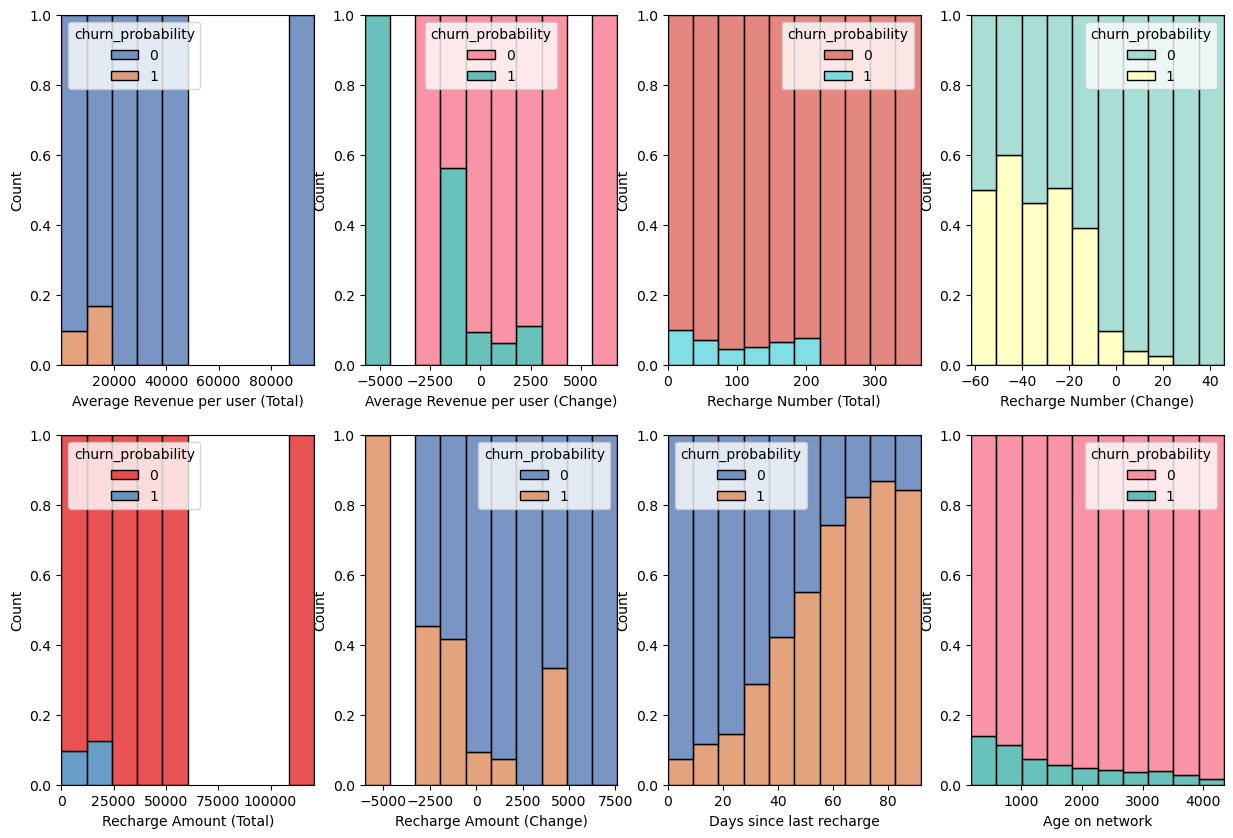

In [30]:
# Draw histplots for features using total statistic
features = [
    {
        "x": "arpu_total",
        "hue": "churn_probability",
        "title": "Average Revenue per user (Total)",
    },
    {
        "x": "arpu_change",
        "hue": "churn_probability",
        "title": "Average Revenue per user (Change)",
    },
    {
        "x": "total_rech_num_total",
        "hue": "churn_probability",
        "title": "Recharge Number (Total)",
    },
    {
        "x": "total_rech_num_change",
        "hue": "churn_probability",
        "title": "Recharge Number (Change)",
    },
    {
        "x": "total_rech_amt_total",
        "hue": "churn_probability",
        "title": "Recharge Amount (Total)",
    },
    {
        "x": "total_rech_amt_change",
        "hue": "churn_probability",
        "title": "Recharge Amount (Change)",
    },
    {
        "x": "days_since_last_rech",
        "hue": "churn_probability",
        "title": "Days since last recharge",
    },
    {
        "x": "aon",
        "hue": "churn_probability",
        "title": "Age on network"
    }
]
draw_hist_plots_with_hue([2, 4], train_data, features)

In [31]:
# Define a function to draw box plots with the given features and choosing colors randomly
def draw_box_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        plot = sns.boxplot(data = data.loc[:, features[i]["columns"]], color = random_color())
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

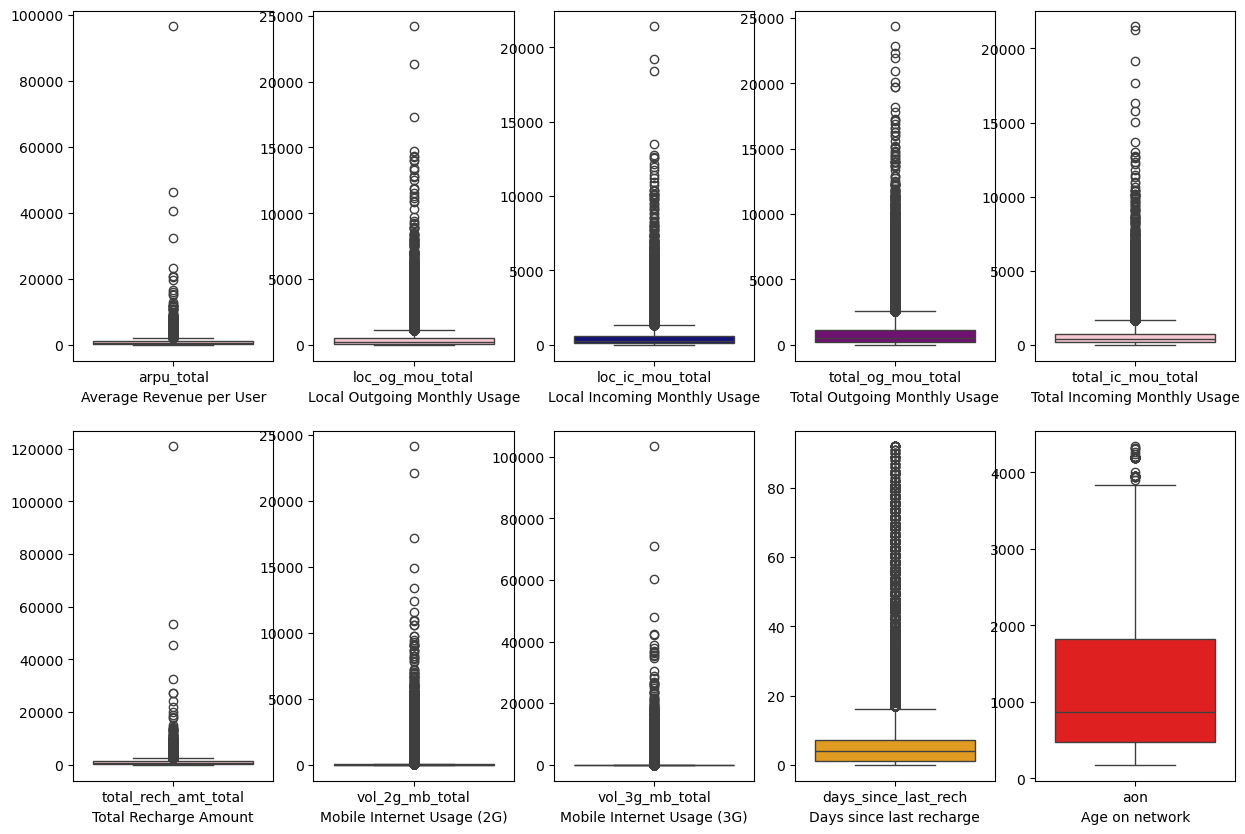

In [32]:
# Draw boxplots for features grouped together for months
features = [
    {
        "columns": [ "arpu_total" ],
        "title": "Average Revenue per User"
    },
    {
        "columns": [ "loc_og_mou_total" ],
        "title": "Local Outgoing Monthly Usage"
    },
    {
        "columns": [ "loc_ic_mou_total" ],
        "title": "Local Incoming Monthly Usage"
    },
    {
        "columns": [ "total_og_mou_total" ],
        "title": "Total Outgoing Monthly Usage"
    },
    {
        "columns": [ "total_ic_mou_total" ],
        "title": "Total Incoming Monthly Usage"
    },
    {
        "columns": [ "total_rech_amt_total" ],
        "title": "Total Recharge Amount"
    },
    {
        "columns": [ "vol_2g_mb_total" ],
        "title": "Mobile Internet Usage (2G)"
    },
    {
        "columns": [ "vol_3g_mb_total" ],
        "title": "Mobile Internet Usage (3G)"
    },
    {
        "columns": [ "days_since_last_rech" ],
        "title": "Days since last recharge"
    },
    {
        "columns": [ "aon" ],
        "title": "Age on network"
    }
]
draw_box_plots([2, 5], train_data, features)

In [33]:
# Removing outliers for various columns where data is beyond 97% quantile
remove_outlier = lambda data, column: data[data[column] < data[column].quantile(0.97)]
columns = ["aon", "arpu_total"]
for column in columns:
    train_data = remove_outlier(train_data, column)

train_data

arpu_6   arpu_7   arpu_8  max_rech_amt_6  max_rech_amt_7  \
0       31.277   87.009    7.527              65              65   
1        0.000  122.787   42.953               0             145   
2       60.806  103.176    0.000              70              70   
3      156.362  205.260  111.095             110             110   
4      240.708  128.191  101.565              50              41   
...        ...      ...      ...             ...             ...   
69236   15.760  410.924  329.136              50             110   
69237  160.083  289.129  265.772              90              44   
69238  372.088  258.374  279.782             279             250   
69239  238.575  245.414  145.062             200             252   
69240  168.269   42.815  167.961             198              50   

       max_rech_amt_8 date_of_last_rech_6 date_of_last_rech_7  \
0                  10          2014-06-22          2014-07-10   
1                  50          2014-06-12          2014-07-10   
2                   0          2014-06-11          2014-07-22   
3                  50          2014-06-15          2014-07-21   
4                  30          2014-06-25          2014-07-26   
...               ...                 ...                 ...   
69236             130          2014-06-18          2014-07-31   
69237              44          2014-06-28          2014-07-31   
69238             349          2014-06-25          2014-07-30   
69239             145          2014-06-29          2014-07-19   
69240             198          2014-06-19          2014-07-27   

      date_of_last_rech_8  last_day_rch_amt_6  last_day_rch_amt_7  \
0              2014-08-24                  65                  65   
1              2014-08-26                   0                   0   
2              2014-08-24                  70                  50   
3              2014-08-25                 110                 110   
4              2014-08-30                  25                  10   
...                   ...                 ...                 ...   
69236          2014-08-31                  50                  20   
69237          2014-08-27                  50                  30   
69238          2014-08-29                 279                 250   
69239          2014-08-26                   0                   0   
69240          2014-08-25                 198                   0   

       last_day_rch_amt_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0                       0  1958        0.00        0.00        0.00   
1                       0   710        0.00        0.00        0.00   
2                       0   882        0.00        0.00        0.00   
3                      50   982        0.00        0.00        0.00   
4                      30   647        0.00        0.00        0.00   
...                   ...   ...         ...         ...         ...   
69236                 130   221        0.00        0.00        0.00   
69237                  42   712        0.00        0.00        0.00   
69238                  48   879        0.00        0.00        0.00   
69239                   0   277      664.25     1402.96      990.97   
69240                   0  1876        0.00        0.00        0.00   

       churn_probability  days_since_last_rech  arpu_total  arpu_change  \
0                      0                     7     125.813     -11.8750   
1                      0                     5     165.740      21.4765   
2                      0                     7     163.982     -30.4030   
3                      0                     6     472.717     -22.6335   
4                      0                     1     470.464     -69.5715   
...                  ...                   ...         ...          ...   
69236                  0                     0     755.820     156.6880   
69237                  0                     4     714.984      52.8445   
69238                  0                     2     91

In [34]:
# Define a function to draw heatmaps with the given features and choosing colors randomly
def draw_heatmaps(data, features, title):
    fig = plt.figure(figsize = (len(features), len(features) * 0.75))
    plot = sns.heatmap(data = data.loc[:, features].corr(), cmap = random_cmap(), annot = True)
    plt.title(title)
    plt.show()

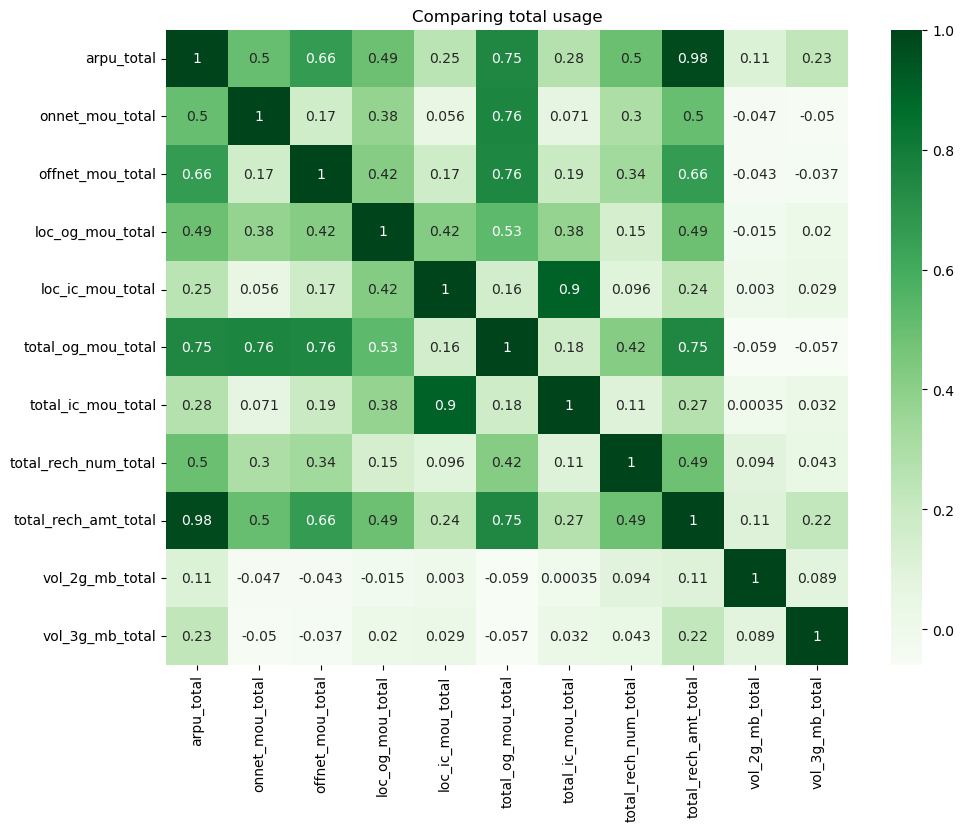

In [35]:
# Draw heatmaps comparing columns for each month separately
columns = ["arpu_total", "onnet_mou_total", "offnet_mou_total", "loc_og_mou_total", "loc_ic_mou_total", "total_og_mou_total", 
           "total_ic_mou_total", "total_rech_num_total", "total_rech_amt_total", "vol_2g_mb_total", "vol_3g_mb_total"]

draw_heatmaps(train_data, columns, "Comparing total usage")

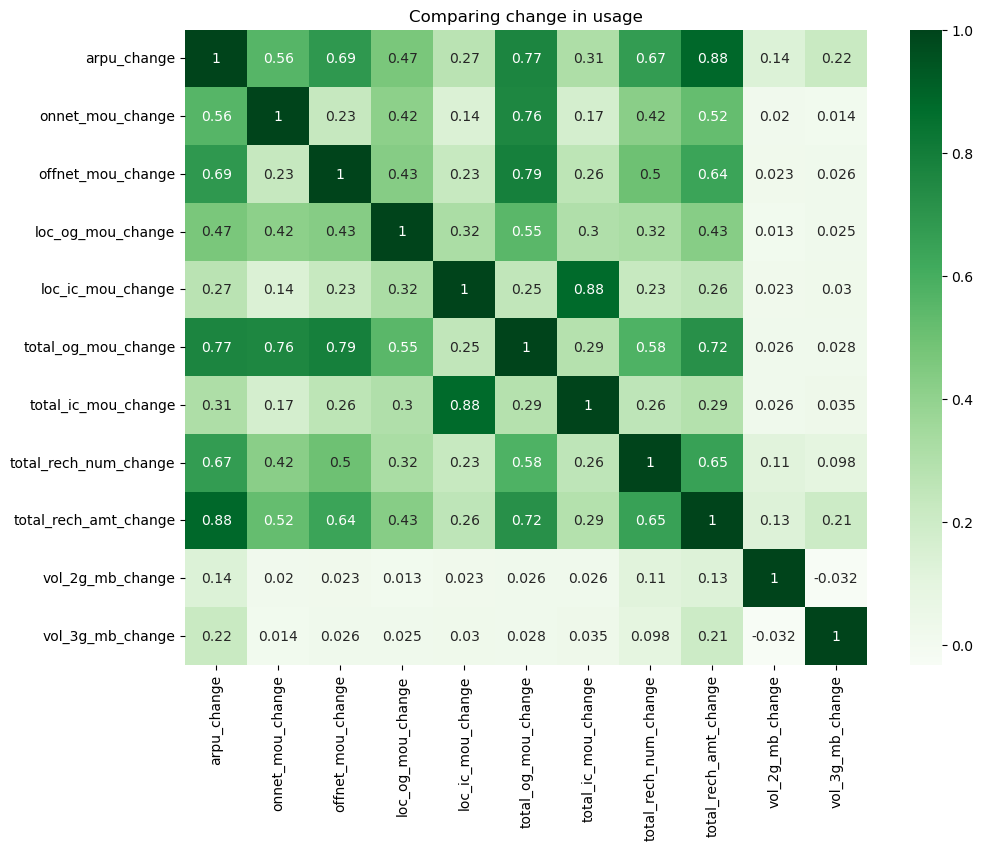

In [36]:
# Draw heatmaps comparing columns for each month separately
columns = ["arpu_change", "onnet_mou_change", "offnet_mou_change", "loc_og_mou_change", "loc_ic_mou_change", "total_og_mou_change", 
           "total_ic_mou_change", "total_rech_num_change", "total_rech_amt_change", "vol_2g_mb_change", "vol_3g_mb_change"]

draw_heatmaps(train_data, columns, "Comparing change in usage")

In [37]:
# Define a function to draw a pair plot with the given features and choosing colors randomly
def draw_pair_plot(data, features, title):
    plot = sns.pairplot(data, vars=features.keys(), diag_kws={"color": random_color()}, plot_kws={"color": random_color()})
    plot.x_vars = features.values()
    plot.y_vars = features.values()
    plot._add_axis_labels()
    plot.fig.suptitle(title, y=1.03, size=20)

    plt.show()

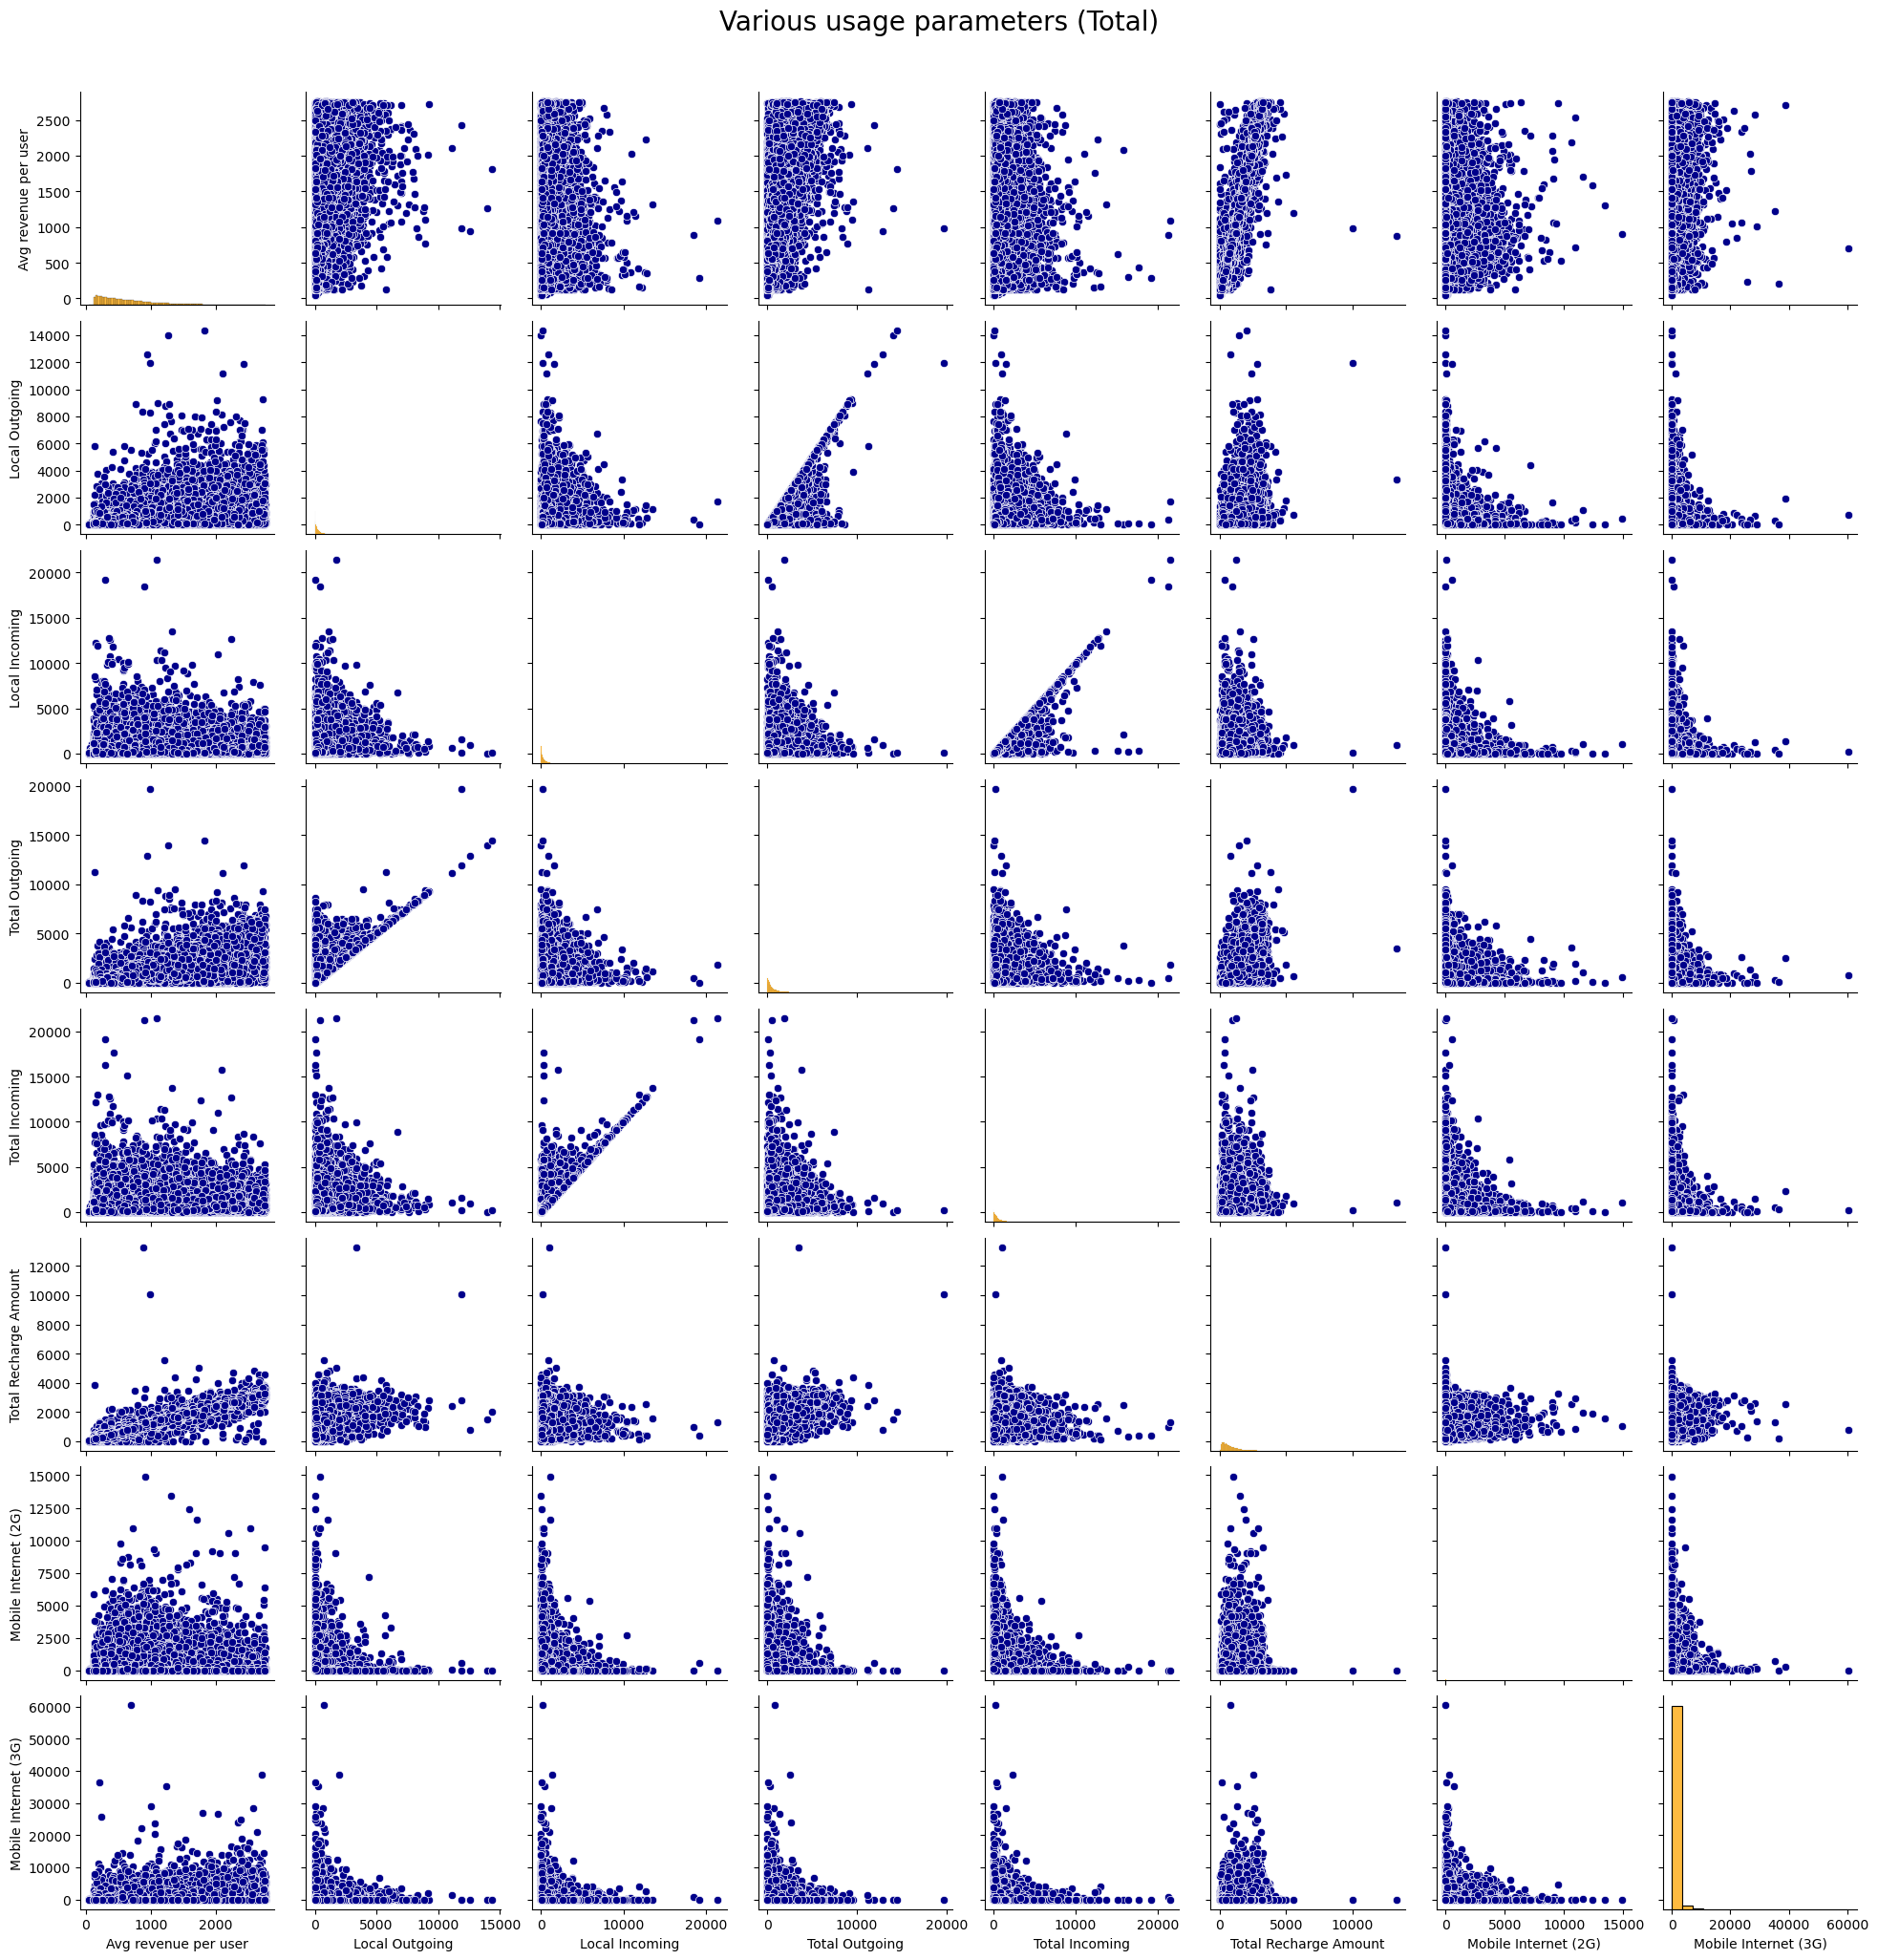

In [38]:
# Pair plot for various usage parameters comparing the total values
features = {
    "arpu_total": "Avg revenue per user", 
    "loc_og_mou_total": "Local Outgoing", 
    "loc_ic_mou_total": "Local Incoming", 
    "total_og_mou_total": "Total Outgoing", 
    "total_ic_mou_total": "Total Incoming", 
    "total_rech_amt_total": "Total Recharge Amount", 
    "vol_2g_mb_total": "Mobile Internet (2G)", 
    "vol_3g_mb_total": "Mobile Internet (3G)"
}

draw_pair_plot(train_data, features, "Various usage parameters (Total)")

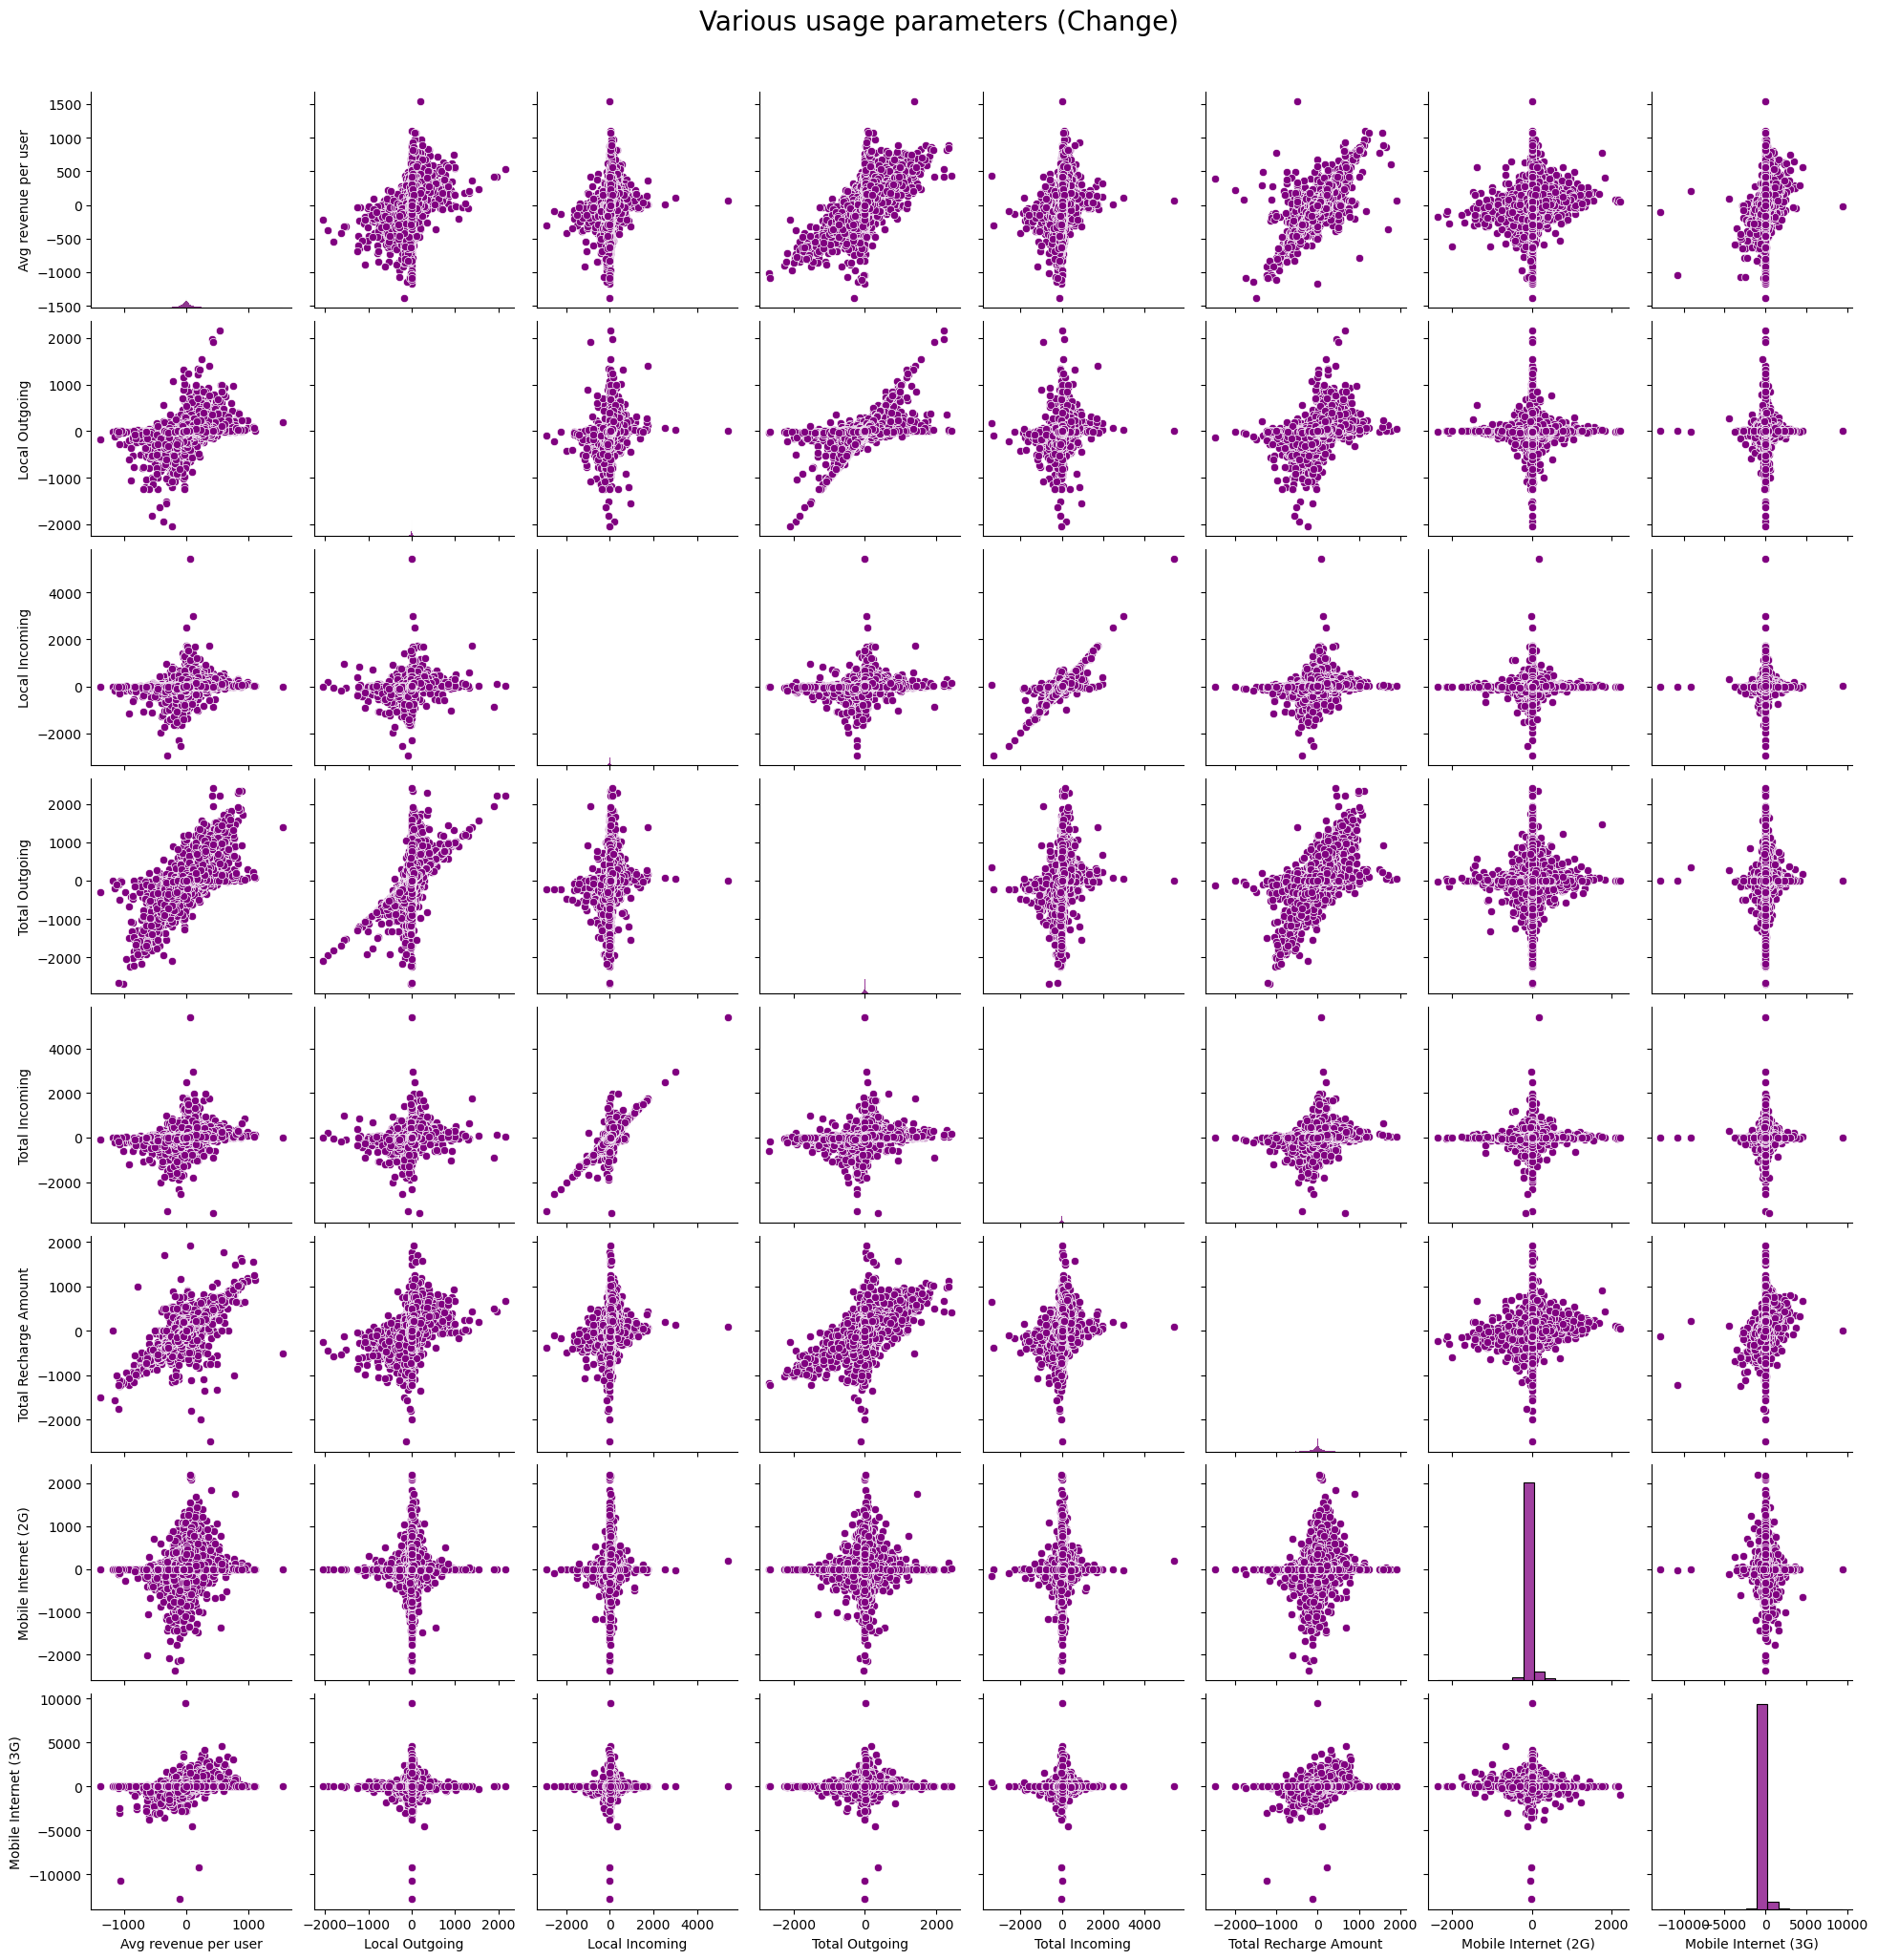

In [39]:
# Pair plot for various usage parameters comparing the change in the values
features = {
    "arpu_change": "Avg revenue per user", 
    "loc_og_mou_change": "Local Outgoing", 
    "loc_ic_mou_change": "Local Incoming", 
    "total_og_mou_change": "Total Outgoing", 
    "total_ic_mou_change": "Total Incoming", 
    "total_rech_amt_change": "Total Recharge Amount", 
    "vol_2g_mb_change": "Mobile Internet (2G)", 
    "vol_3g_mb_change": "Mobile Internet (3G)"
}

draw_pair_plot(train_data, features, "Various usage parameters (Change)")

# Data Preparation

In [40]:
# Remove non-numeric columns from training data
final_train_data = train_data.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8", "max_rech_amt_6",
                                    "max_rech_amt_7", "max_rech_amt_8", "last_day_rch_amt_6", "last_day_rch_amt_7", 
                                    "last_day_rch_amt_8"], axis=1)
final_train_data

arpu_6   arpu_7   arpu_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0       31.277   87.009    7.527  1958        0.00        0.00        0.00   
1        0.000  122.787   42.953   710        0.00        0.00        0.00   
2       60.806  103.176    0.000   882        0.00        0.00        0.00   
3      156.362  205.260  111.095   982        0.00        0.00        0.00   
4      240.708  128.191  101.565   647        0.00        0.00        0.00   
...        ...      ...      ...   ...         ...         ...         ...   
69236   15.760  410.924  329.136   221        0.00        0.00        0.00   
69237  160.083  289.129  265.772   712        0.00        0.00        0.00   
69238  372.088  258.374  279.782   879        0.00        0.00        0.00   
69239  238.575  245.414  145.062   277      664.25     1402.96      990.97   
69240  168.269   42.815  167.961  1876        0.00        0.00        0.00   

       churn_probability  days_since_last_rech  arpu_total  arpu_change  \
0                      0                     7     125.813     -11.8750   
1                      0                     5     165.740      21.4765   
2                      0                     7     163.982     -30.4030   
3                      0                     6     472.717     -22.6335   
4                      0                     1     470.464     -69.5715   
...                  ...                   ...         ...          ...   
69236                  0                     0     755.820     156.6880   
69237                  0                     4     714.984      52.8445   
69238                  0                     2     910.244     -46.1530   
69239                  0                     5     629.051     -46.7565   
69240                  0                     6     379.045      -0.1540   

       onnet_mou_total  onnet_mou_change  offnet_mou_total  offnet_mou_change  \
0               174.25           -23.645            131.25            -14.955   
1                 0.00             0.000             56.88             15.445   
2                16.46            -0.265            136.04            -26.995   
3                23.27            -3.630            197.47             -9.265   
4                32.24            -7.575            104.73            -23.680   
...                ...               ...               ...                ...   
69236            18.29             5.465            870.10            190.820   
69237           545.63            58.045            193.87             -0.735   
69238           224.01             0.655            827.32            -35.850   
69239            28.36            -3.650             59.58             -8.890   
69240             0.00             0.000              0.00              0.000   

       loc_og_mou_total  loc_og_mou_change  std_og_mou_total  \
0                 26.18             -2.460            271.09   
1                  0.00              0.000              0.00   
2                 37.62            -12.320            113.93   
3                117.38            -10.640             58.75   
4                100.61            -21.575              4.35   
...                 ...                ...               ...   
69236            159.95             48.430            713.41   
69237            207.10              4.840            528.19   
69238            973.33            -10.310             24.16   
69239             57.52             -2.450             25.86   
69240              0.00              0.000              0.00   

       std_og_mou_change  isd_og_mou_total  isd_og_mou_change  \
0                -32.040              0.00              0.000   
1                  0.000              0.00              0.000   
2                -14.470              0.00              0.000   
3                 -5.780              0.00              0.000   
4                 -2.175              0.00              0.000   
...                  ...              

In [41]:
# Separate data into feature and target set
final_y_train_data = final_train_data.pop("churn_probability")
final_X_train_data = final_train_data

# Separate data into training and testing data
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(final_X_train_data, final_y_train_data,
                                                                        train_size = 0.8, 
                                                                        random_state = 42)

# Print top 5 records from feature training set
X_train_data.head()

arpu_6   arpu_7   arpu_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
29332  158.371    0.750    6.000   291        0.00         0.0         0.0   
8830   441.475  518.447  368.745  1003        0.00         0.0         0.0   
24239  185.768    0.000    0.100   648        0.00         0.0         0.0   
66708   68.174  251.106    8.190   210        0.00         0.0         0.0   
59154  213.275   83.282  178.390   287       12.08        89.3         0.0   

       days_since_last_rech  arpu_total  arpu_change  onnet_mou_total  \
29332                     2     165.121     -76.1855            17.50   
8830                      5    1328.667     -36.3650          1013.85   
24239                    46     185.868     -92.8340            93.61   
66708                    20     327.470     -29.9920            92.07   
59154                     9     474.947     -17.4425             3.48   

       onnet_mou_change  offnet_mou_total  offnet_mou_change  \
29332            -8.750             79.83            -38.715   
8830             90.835            858.62             40.740   
24239           -46.805            124.33            -62.165   
66708            -8.055            189.40            -17.030   
59154             1.740             12.58              6.290   

       loc_og_mou_total  loc_og_mou_change  std_og_mou_total  \
29332             42.61            -21.305             53.51   
8830              68.45            -10.470           1768.02   
24239             67.53            -33.765             97.11   
66708             96.92             -7.745            184.51   
59154             16.06              8.030              0.00   

       std_og_mou_change  isd_og_mou_total  isd_og_mou_change  \
29332            -26.755              0.00              0.000   
8830             133.900              3.01             -1.505   
24239            -48.555              0.00              0.000   
66708            -17.340              0.00              0.000   
59154              0.000              0.00              0.000   

       spl_og_mou_total  spl_og_mou_change  og_others_total  og_others_change  \
29332              1.20              0.600             0.00              0.00   
8830              37.34             11.840             0.00              0.00   
24239              7.82             -3.505             1.86             -0.93   
66708             11.05              2.000             0.00              0.00   
59154              1.08              0.440             1.30             -0.65   

       total_og_mou_total  total_og_mou_change  loc_ic_mou_total  \
29332               97.33              -47.465             81.74   
8830              1876.86              133.770            101.86   
24239              174.34              -86.765             42.21   
66708              292.50              -23.090            230.30   
59154               18.44                7.820            108.07   

       loc_ic_mou_change  std_ic_mou_total  std_ic_mou_change  \
29332            -38.250             33.01            -16.505   
8830             -33.550            141.69              2.435   
24239            -16.905            113.12            -29.790   
66708            -42.135            347.37            -17.550   
59154            -13.940              0.00              0.000   

       isd_ic_mou_total  isd_ic_mou_change  spl_ic_mou_total  \
29332              0.00              0.000              0.00   
8830               0.00              0.000              0.00   
24239              0.00              0.000              0.00   
66708              0.00              0.000              0.18   
59154              0.41             -0.205              0.32   

       spl_ic_mou_change  ic_others_total  ic_others_change  \
29332               0.00             0.43            -0.085   
8830                0.00             0.00             0.000   
24239               0.00             0.00             0.000   
66708          

In [42]:
# Rescale all features using Standard Scaler, use columns which are numeric
scaler = StandardScaler()
X_train_data[X_train_data.columns] = scaler.fit_transform(X_train_data[X_train_data.columns])
X_test_data[X_train_data.columns] = scaler.transform(X_test_data[X_train_data.columns])

# Print first 5 rows of training set
X_train_data.head()

arpu_6    arpu_7    arpu_8       aon  aug_vbc_3g  jul_vbc_3g  \
29332 -0.413162 -1.110369 -1.064742 -0.984987   -0.262863   -0.248431   
8830   0.836525  1.246257  0.544882 -0.170643   -0.262863   -0.248431   
24239 -0.292226 -1.113783 -1.090922 -0.576671   -0.262863   -0.248431   
66708 -0.811313  0.029285 -1.055024 -1.077630   -0.262863   -0.248431   
59154 -0.170803 -0.734672 -0.299788 -0.989562   -0.209133    0.142099   

       jun_vbc_3g  days_since_last_rech  arpu_total  arpu_change  \
29332   -0.234794             -0.497258   -1.032902    -0.598637   
8830    -0.234794             -0.190673    1.048293    -0.272875   
24239   -0.234794              3.999334   -0.995792    -0.734834   
66708   -0.234794              1.342257   -0.742514    -0.220739   
59154   -0.234794              0.218109   -0.478727    -0.118075   

       onnet_mou_total  onnet_mou_change  offnet_mou_total  offnet_mou_change  \
29332        -0.497971         -0.053761         -0.658194          -0.274308   
8830          1.026488          0.757488          0.553109           0.335653   
24239        -0.381519         -0.363769         -0.588980          -0.454330   
66708        -0.383875         -0.048100         -0.487773          -0.107837   
59154        -0.519422          0.031693         -0.762792           0.071186   

       loc_og_mou_total  loc_og_mou_change  std_og_mou_total  \
29332         -0.573568          -0.218882         -0.468929   
8830          -0.528098          -0.088243          1.609588   
24239         -0.529717          -0.369115         -0.416073   
66708         -0.478000          -0.055387         -0.310117   
59154         -0.620287           0.134815         -0.533800   

       std_og_mou_change  isd_og_mou_total  isd_og_mou_change  \
29332          -0.160111         -0.067867           0.004865   
8830            0.800857          0.143459          -0.470264   
24239          -0.290509         -0.067867           0.004865   
66708          -0.103795         -0.067867           0.004865   
59154          -0.000074         -0.067867           0.004865   

       spl_og_mou_total  spl_og_mou_change  og_others_total  og_others_change  \
29332         -0.271701           0.010096        -0.103131          0.093664   
8830           0.553809           1.316269        -0.103131          0.093664   
24239         -0.120487          -0.466935         0.298090         -0.347272   
66708         -0.046707           0.172787        -0.103131          0.093664   
59154         -0.274442          -0.008497         0.177292         -0.214517   

       total_og_mou_total  total_og_mou_change  loc_ic_mou_total  \
29332           -0.740900            -0.223278         -0.562065   
8830             1.074883             0.683501         -0.532268   
24239           -0.662321            -0.419909         -0.620607   
66708           -0.541754            -0.101322         -0.342054   
59154           -0.821398             0.053331         -0.523071   

       loc_ic_mou_change  std_ic_mou_total  std_ic_mou_change  \
29332          -0.388655         -0.208040          -0.352436   
8830           -0.339135          0.185069           0.052148   
24239          -0.163761          0.081728          -0.636222   
66708          -0.429587          0.929038          -0.374759   
59154          -0.132522         -0.327441           0.000133   

       isd_ic_mou_total  isd_ic_mou_change  spl_ic_mou_total  \
29332         -0.136288          -0.016305         -0.429481   
8830          -0.136288          -0.016305         -0.429481   
24239         -0.136288          -0.016305         -0.429481   
66708         -0.136288          -0.016305          0.144837   
59154         -0.133676          -0.024999          0.591529   

       spl_ic_mou_change  ic_others_total  ic_others_change  \
29332           0.105532        -0.074478         -0.024612   
8830            0.105532        -0.089857         -0.009725   
24239           0.105532        -0.08

In [43]:
# Initialize PCA and create 25 components
pca = PCA(n_components = 25, random_state = 42)
pca_train_components = pca.fit_transform(X_train_data)
pca_test_components = pca.transform(X_test_data)
pca.components_

array([[ 0.25679079,  0.32033447,  0.31596171, ...,  0.04467661,
         0.11126268,  0.01977945],
       [-0.247466  , -0.03900731,  0.14646145, ...,  0.34796578,
        -0.0229248 ,  0.05600079],
       [-0.02419899, -0.02631184, -0.01312358, ...,  0.01446954,
         0.42781972,  0.02929055],
       ...,
       [-0.03861089, -0.03896732, -0.01643537, ...,  0.03338019,
         0.04036873, -0.06403006],
       [ 0.0042097 ,  0.00046517,  0.01840947, ...,  0.0298191 ,
         0.01653927,  0.11216187],
       [-0.00764483, -0.02998333, -0.03650359, ..., -0.00738372,
         0.0107731 , -0.17620203]])

In [44]:
# Select the top 15 components for use in model building
selected_components = 15
pca_X_train_data = pca_train_components[:, :selected_components]
pca_X_test_data = pca_test_components[:, :selected_components]

# Model Building

In [45]:
# Define a function to print various metrics comparing the actual and prediction
model_metrics = pd.DataFrame(columns = ["model", "parameters", "confusion_matrix", "accuracy_score", "precision_score", "recall_score", 
                                        "roc_auc_score", "r2_score", "mean_squared_error"])

def print_metrics(model, parameters, actual, prediction, model_metrics):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    print("Confusion Matrix = \n", confusion_matrix)

    accuracy_score = round(metrics.accuracy_score(actual, prediction), 2)
    print("Accuracy score =", accuracy_score)

    precision_score = round(metrics.precision_score(actual, prediction), 2)
    print("Precision score =", precision_score)

    recall_score = round(metrics.recall_score(actual, prediction), 2)
    print("Recall score =", recall_score)

    roc_auc_score = round(metrics.roc_auc_score(actual, prediction), 2)
    print("ROC AUC score =", roc_auc_score)

    r2_score = round(metrics.r2_score(actual, prediction), 2)
    print("R2 score =", r2_score)

    mse = round(metrics.mean_squared_error(actual, prediction), 2)
    print("Mean squared error =", mse)

    model_metrics.loc[len(model_metrics)] = (model, parameters, confusion_matrix, accuracy_score, precision_score, recall_score,
                                            roc_auc_score, r2_score, mse)
    return model_metrics

## Logistic Regression

In [46]:
# Initialize Logistic Regression model, and select features using RFE in a GridSearch
# Parameters to tune: n_features_to_select

params = {
    "n_features_to_select": [5, 10, 15, 20]
}
grid_search_logistic = GridSearchCV(estimator = RFE(estimator = LogisticRegression(random_state = 42)),
                                    param_grid = params, 
                                    cv = 4, 
                                    n_jobs = -1, 
                                    scoring = "accuracy", 
                                    verbose = True)
X_train_data_lm = sm.add_constant(X_train_data)
grid_search_logistic.fit(X_train_data_lm, y_train_data)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4, estimator=RFE(estimator=LogisticRegression(random_state=42)),
             n_jobs=-1, param_grid={'n_features_to_select': [5, 10, 15, 20]},
             scoring='accuracy', verbose=True)

In [47]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_logistic.best_score_)
print("Best Parameters =", grid_search_logistic.best_params_)
logistic_rfe = grid_search_logistic.best_estimator_
logistic_rfe

Best Score = 0.9148854035218796
Best Parameters = {'n_features_to_select': 20}


RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=20)

In [48]:
# Print the wieghtage of each column after RFE and store the selected columns
selected_columns = X_train_data_lm.columns[logistic_rfe.support_]
list(zip(X_train_data_lm.columns, logistic_rfe.support_, logistic_rfe.ranking_))

[('const', True, 1),
 ('arpu_6', False, 13),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('aon', True, 1),
 ('aug_vbc_3g', True, 1),
 ('jul_vbc_3g', False, 27),
 ('jun_vbc_3g', False, 26),
 ('days_since_last_rech', True, 1),
 ('arpu_total', False, 14),
 ('arpu_change', False, 12),
 ('onnet_mou_total', True, 1),
 ('onnet_mou_change', True, 1),
 ('offnet_mou_total', True, 1),
 ('offnet_mou_change', True, 1),
 ('loc_og_mou_total', True, 1),
 ('loc_og_mou_change', False, 7),
 ('std_og_mou_total', True, 1),
 ('std_og_mou_change', False, 17),
 ('isd_og_mou_total', False, 35),
 ('isd_og_mou_change', False, 38),
 ('spl_og_mou_total', False, 19),
 ('spl_og_mou_change', False, 18),
 ('og_others_total', False, 31),
 ('og_others_change', False, 30),
 ('total_og_mou_total', True, 1),
 ('total_og_mou_change', True, 1),
 ('loc_ic_mou_total', True, 1),
 ('loc_ic_mou_change', True, 1),
 ('std_ic_mou_total', False, 34),
 ('std_ic_mou_change', False, 9),
 ('isd_ic_mou_total', False, 8),
 ('isd_ic_mou_ch

In [49]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = logistic_rfe.predict(X_train_data_lm)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'churn_probability': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred['prediction'] = y_train_data_pred.churn_probability.map(lambda prob: 1 if prob > 0.5 else 0)
y_train_data_pred

churn  churn_probability     id  prediction
0          1                  0  29332           0
1          0                  0   8830           0
2          0                  1  24239           1
3          0                  0  66708           0
4          0                  0  59154           0
...      ...                ...    ...         ...
52113      1                  0  66509           0
52114      0                  0  40509           0
52115      0                  0    913           0
52116      0                  1  16733           1
52117      0                  0  59976           0

[52118 rows x 4 columns]

In [50]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with RFE (Training Data)', 
                              {'n_features_to_select': logistic_rfe.n_features_to_select}, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46411   590]
 [ 3829  1288]]
Accuracy score = 0.92
Precision score = 0.69
Recall score = 0.25
ROC AUC score = 0.62
R2 score = 0.04
Mean squared error = 0.08


In [51]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
X_test_data_lm = sm.add_constant(X_test_data)
y_test_data_pred = logistic_rfe.predict(X_test_data_lm)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           1
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [52]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with RFE (Testing Data)', 
                              {'n_features_to_select': logistic_rfe.n_features_to_select}, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11593   145]
 [  976   316]]
Accuracy score = 0.91
Precision score = 0.69
Recall score = 0.24
ROC AUC score = 0.62
R2 score = 0.04
Mean squared error = 0.09


## Random Forest

In [53]:
# Initialize Random Forest model in a GridSearch
# Parameters to tune: n_estimators, max_depth, max_features, min_samples_leaf

params = {
    "n_estimators": [50, 75, 100],
    "max_depth": [7, 10, 12],
    "max_features": [10, 12, 15],
    "min_samples_leaf": [20, 25, 35]
}
grid_search_random_forest = GridSearchCV(estimator = RandomForestClassifier(random_state = 42),
                                  param_grid = params, 
                                  cv = 4, 
                                  n_jobs = -1, 
                                  scoring = "accuracy", 
                                  verbose = True)
grid_search_random_forest.fit(X_train_data, y_train_data)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12], 'max_features': [10, 12, 15],
                         'min_samples_leaf': [20, 25, 35],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy', verbose=True)

In [54]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_random_forest.best_score_)
print("Best Parameters =", grid_search_random_forest.best_params_)
random_forest = grid_search_random_forest.best_estimator_
random_forest

Best Score = 0.932460899403403
Best Parameters = {'max_depth': 12, 'max_features': 15, 'min_samples_leaf': 20, 'n_estimators': 100}


RandomForestClassifier(max_depth=12, max_features=15, min_samples_leaf=20,
                       random_state=42)

In [55]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = random_forest.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'id': y_train_data.index, 'prediction': y_train_data_pred })
y_train_data_pred

churn     id  prediction
0          1  29332           0
1          0   8830           0
2          0  24239           1
3          0  66708           0
4          0  59154           0
...      ...    ...         ...
52113      1  66509           1
52114      0  40509           0
52115      0    913           0
52116      0  16733           0
52117      0  59976           0

[52118 rows x 3 columns]

In [56]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Training Data)', 
                              grid_search_random_forest.best_params_, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46330   671]
 [ 2480  2637]]
Accuracy score = 0.94
Precision score = 0.8
Recall score = 0.52
ROC AUC score = 0.75
R2 score = 0.32
Mean squared error = 0.06


In [57]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
y_test_data_pred = random_forest.predict(X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           1
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [58]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Testing Data)', 
                              grid_search_random_forest.best_params_, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11539   199]
 [  671   621]]
Accuracy score = 0.93
Precision score = 0.76
Recall score = 0.48
ROC AUC score = 0.73
R2 score = 0.25
Mean squared error = 0.07


## XGBoost Classifier

In [59]:
# Initialize XGBoost Classifier model in a RandomizedSearch
# Parameters to tune: n_estimators, learning_rate, min_child_weight, gamma, max_depth

params = {
    "n_estimators": [25, 50, 75, 100],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "gamma": [0.25, 0.5, 1],
    "min_child_weight": [1, 5, 7]
}
random_search_xgb = RandomizedSearchCV(estimator = xgb.XGBClassifier(random_state = 42),
                                       param_distributions = params,
                                       cv = 4,
                                       n_iter = 1000,
                                       n_jobs = -1,
                                       scoring = "accuracy",
                                       verbose = True)
random_search_xgb.fit(X_train_data, y_train_data)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'gamma': [0.25, 0.5, 1],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [7, 10, 15],
                                        'min_child_weight': [1, 5, 7],
                                        'n_estimators': [25, 50, 75, 100]},
                   scoring='accuracy', verbose=True)

In [60]:
# Print the best score, parameters and model obtained from random search
print("Best Score =", random_search_xgb.best_score_)
print("Best Parameters =", random_search_xgb.best_params_)
xg_boost = random_search_xgb.best_estimator_
xg_boost

Best Score = 0.9345331245541338
Best Parameters = {'n_estimators': 50, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.25}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [61]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = xg_boost.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'id': y_train_data.index, 'prediction': y_train_data_pred })
y_train_data_pred

churn     id  prediction
0          1  29332           1
1          0   8830           0
2          0  24239           0
3          0  66708           0
4          0  59154           0
...      ...    ...         ...
52113      1  66509           1
52114      0  40509           0
52115      0    913           0
52116      0  16733           0
52117      0  59976           0

[52118 rows x 3 columns]

In [62]:
# Print metrics and add them to data frame for comparison
model_metrics = print_metrics('XGBoost (Training Data)', 
                              random_search_xgb.best_params_, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46309   692]
 [ 1734  3383]]
Accuracy score = 0.95
Precision score = 0.83
Recall score = 0.66
ROC AUC score = 0.82
R2 score = 0.47
Mean squared error = 0.05


In [63]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
y_test_data_pred = xg_boost.predict(X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           1
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [64]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('XGBoost (Testing Data)', 
                              random_search_xgb.best_params_, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11470   268]
 [  609   683]]
Accuracy score = 0.93
Precision score = 0.72
Recall score = 0.53
ROC AUC score = 0.75
R2 score = 0.25
Mean squared error = 0.07


## PCA + Logistic Regression

In [65]:
# Initialize logistic regression and fit with PCA transformed data
pca_logistic = LogisticRegression(random_state = 42)
pca_X_train_data_lm = sm.add_constant(pca_X_train_data)
pca_logistic.fit(pca_X_train_data_lm, y_train_data)

LogisticRegression(random_state=42)

In [66]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = pca_logistic.predict(pca_X_train_data_lm)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'prediction': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred

churn  prediction     id
0          1           0  29332
1          0           0   8830
2          0           1  24239
3          0           0  66708
4          0           0  59154
...      ...         ...    ...
52113      1           0  66509
52114      0           0  40509
52115      0           0    913
52116      0           0  16733
52117      0           0  59976

[52118 rows x 3 columns]

In [67]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with PCA (Training Data)', 
                              {'n_components': pca.n_components, 'selected_components': selected_components}, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46593   408]
 [ 4068  1049]]
Accuracy score = 0.91
Precision score = 0.72
Recall score = 0.21
ROC AUC score = 0.6
R2 score = 0.03
Mean squared error = 0.09


In [68]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
pca_X_test_data_lm = sm.add_constant(pca_X_test_data)
y_test_data_pred = pca_logistic.predict(pca_X_test_data_lm)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           0
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [69]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with PCA (Testing Data)', 
                              {'n_components': pca.n_components, 'selected_components': selected_components}, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11632   106]
 [ 1039   253]]
Accuracy score = 0.91
Precision score = 0.7
Recall score = 0.2
ROC AUC score = 0.59
R2 score = 0.02
Mean squared error = 0.09


## PCA + Random Forest

In [70]:
# Initialize Random Forest model in a GridSearch
# Parameters to tune: n_estimators, max_depth, max_features, min_samples_leaf
params = {
    "n_estimators": [50, 75, 100],
    "max_depth": [5, 7, 10],
    "max_features": [5, 10, 12],
    "min_samples_leaf": [20, 25, 35]
}
grid_search_random_forest = GridSearchCV(estimator = RandomForestClassifier(random_state = 42),
                                  param_grid = params, 
                                  cv = 4, 
                                  n_jobs = -1, 
                                  scoring = "accuracy", 
                                  verbose = True)
grid_search_random_forest.fit(pca_X_train_data, y_train_data)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10], 'max_features': [5, 10, 12],
                         'min_samples_leaf': [20, 25, 35],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy', verbose=True)

In [71]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_random_forest.best_score_)
print("Best Parameters =", grid_search_random_forest.best_params_)
pca_random_forest = grid_search_random_forest.best_estimator_
pca_random_forest

Best Score = 0.91822398725978
Best Parameters = {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 20, 'n_estimators': 50}


RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=20,
                       n_estimators=50, random_state=42)

In [72]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = pca_random_forest.predict(pca_X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'prediction': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred

churn  prediction     id
0          1           1  29332
1          0           0   8830
2          0           1  24239
3          0           0  66708
4          0           0  59154
...      ...         ...    ...
52113      1           1  66509
52114      0           0  40509
52115      0           0    913
52116      0           0  16733
52117      0           0  59976

[52118 rows x 3 columns]

In [73]:
# Print metrics and add them to dataframe for comparison
parameters = grid_search_random_forest.best_params_
parameters['n_components'] = pca.n_components
model_metrics = print_metrics('Random Forest with PCA (Training Data)', 
                              parameters, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46453   548]
 [ 3108  2009]]
Accuracy score = 0.93
Precision score = 0.79
Recall score = 0.39
ROC AUC score = 0.69
R2 score = 0.21
Mean squared error = 0.07


In [74]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
y_test_data_pred = pca_random_forest.predict(pca_X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           1
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [75]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest with PCA (Testing Data)', 
                              parameters, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11546   192]
 [  881   411]]
Accuracy score = 0.92
Precision score = 0.68
Recall score = 0.32
ROC AUC score = 0.65
R2 score = 0.08
Mean squared error = 0.08


## Gaussian Naive Bayes

In [76]:
# Initialize Gaussian Naive Bayes model in a GridSearch
# Parameters to tune: var_smoothing
params = {
    'var_smoothing': np.logspace(0, -9, num = 100)
}

grid_search_naive_bayes = GridSearchCV(estimator = GaussianNB(), 
                                       param_grid = params, 
                                       cv = 4,
                                       verbose = 1,
                                       scoring = 'accuracy')
grid_search_naive_bayes.fit(pca_X_train_data, y_train_data)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [77]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_naive_bayes.best_score_)
print("Best Parameters =", grid_search_naive_bayes.best_params_)
naive_bayes = grid_search_naive_bayes.best_estimator_
naive_bayes

Best Score = 0.9026823420709702
Best Parameters = {'var_smoothing': 1.0}


GaussianNB(var_smoothing=1.0)

In [78]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = naive_bayes.predict(pca_X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'id': y_train_data.index, 'prediction': y_train_data_pred })
y_train_data_pred

churn     id  prediction
0          1  29332           0
1          0   8830           0
2          0  24239           0
3          0  66708           0
4          0  59154           0
...      ...    ...         ...
52113      1  66509           0
52114      0  40509           0
52115      0    913           0
52116      0  16733           0
52117      0  59976           0

[52118 rows x 3 columns]

In [79]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Naive Bayes (Training Data)', 
                              grid_search_naive_bayes.best_params_, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[46854   147]
 [ 4938   179]]
Accuracy score = 0.9
Precision score = 0.55
Recall score = 0.03
ROC AUC score = 0.52
R2 score = -0.1
Mean squared error = 0.1


In [80]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model for testing data
y_test_data_pred = naive_bayes.predict(pca_X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn': y_test_data.values, 'id': y_test_data.index, 'prediction': y_test_data_pred })
y_test_data_pred

churn     id  prediction
0          0  13761           0
1          0  32901           0
2          0  53514           0
3          0  37752           0
4          0   8821           0
...      ...    ...         ...
13025      0  60154           0
13026      1   7684           0
13027      0  35174           0
13028      0  66295           0
13029      0   1189           0

[13030 rows x 3 columns]

In [81]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Naive Bayes (Testing Data)', 
                              grid_search_naive_bayes.best_params_, 
                              y_test_data_pred.churn, 
                              y_test_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[11691    47]
 [ 1248    44]]
Accuracy score = 0.9
Precision score = 0.48
Recall score = 0.03
ROC AUC score = 0.52
R2 score = -0.11
Mean squared error = 0.1


# Model Selection, Evaluation and Prediction

In [82]:
# Print a comparison of all the above models along with the various scores
model_metrics

model  \
0   Logistic Regression with RFE (Training Data)   
1    Logistic Regression with RFE (Testing Data)   
2                  Random Forest (Training Data)   
3                   Random Forest (Testing Data)   
4                        XGBoost (Training Data)   
5                         XGBoost (Testing Data)   
6   Logistic Regression with PCA (Training Data)   
7    Logistic Regression with PCA (Testing Data)   
8         Random Forest with PCA (Training Data)   
9          Random Forest with PCA (Testing Data)   
10                   Naive Bayes (Training Data)   
11                    Naive Bayes (Testing Data)   

                                           parameters  \
0                        {'n_features_to_select': 20}   
1                        {'n_features_to_select': 20}   
2   {'max_depth': 12, 'max_features': 15, 'min_sam...   
3   {'max_depth': 12, 'max_features': 15, 'min_sam...   
4   {'n_estimators': 50, 'min_child_weight': 7, 'm...   
5   {'n_estimators': 50, 'min_child_weight': 7, 'm...   
6     {'n_components': 25, 'selected_components': 15}   
7     {'n_components': 25, 'selected_components': 15}   
8   {'max_depth': 10, 'max_features': 10, 'min_sam...   
9   {'max_depth': 10, 'max_features': 10, 'min_sam...   
10                             {'var_smoothing': 1.0}   
11                             {'var_smoothing': 1.0}   

                confusion_matrix  accuracy_score  precision_score  \
0   [[46411, 590], [3829, 1288]]            0.92             0.69   
1     [[11593, 145], [976, 316]]            0.91             0.69   
2   [[46330, 671], [2480, 2637]]            0.94             0.80   
3     [[11539, 199], [671, 621]]            0.93             0.76   
4   [[46309, 692], [1734, 3383]]            0.95             0.83   
5     [[11470, 268], [609, 683]]            0.93             0.72   
6   [[46593, 408], [4068, 1049]]            0.91             0.72   
7    [[11632, 106], [1039, 253]]            0.91             0.70   
8   [[46453, 548], [3108, 2009]]            0.93             0.79   
9     [[11546, 192], [881, 411]]            0.92             0.68   
10   [[46854, 147], [4938, 179]]            0.90             0.55   
11     [[11691, 47], [1248, 44]]            0.90             0.48   

    recall_score  roc_auc_score  r2_score  mean_squared_error  
0           0.25           0.62      0.04                0.08  
1           0.24           0.62      0.04                0.09  
2           0.52           0.75      0.32                0.06  
3           0.48           0.73      0.25                0.07  
4           0.66           0.82      0.47                0.05  
5           0.53           0.75      0.25                0.07  
6           0.21           0.60      0.03                0.09  
7           0.20           0.59      0.02                0.09  
8           0.39           0.69      0.21                0.07  
9           0.32           0.65      0.08                0.08  
10          0.03           0.52     -0.10                0.10  
11          0.03           0.52     -0.11                0.10

In [83]:
# Set the finally selected model and set whether it was with PCA or not
final_model = random_forest
isPCA = False

In [84]:
# If PCA is set to true, transform data to pca components and prepare X_train_data
if isPCA == True:
    X_train_data = pca_train_components[:, :selected_components]

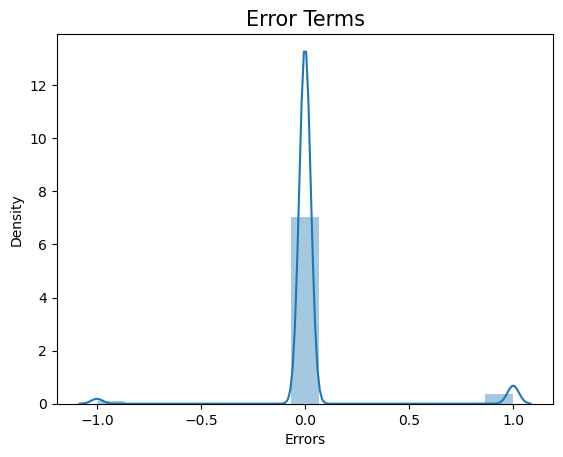

In [85]:
# Plot the error terms as residual plot for the finalized model
y_train_data_pred = final_model.predict(X_train_data)
sns.distplot((y_train_data - y_train_data_pred), bins = 15)
plt.title("Error Terms", fontsize = 15)
plt.xlabel("Errors")
plt.show()

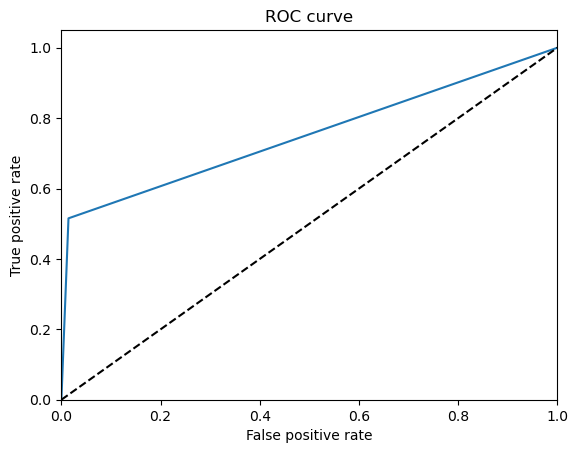

In [86]:
# Plot the ROC curve for the finalized model
fpr, tpr, thresholds = metrics.roc_curve(y_train_data, y_train_data_pred, drop_intermediate = False)
roc_auc_score = metrics.roc_auc_score(y_train_data, y_train_data_pred)
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

In [87]:
# Print Feature importance for the parameters
final_model.feature_importances_

array([1.05265808e-02, 1.90892913e-02, 3.63182639e-01, 8.39808400e-03,
       4.81805310e-03, 7.41479973e-04, 4.15634221e-04, 6.15859090e-02,
       1.04021758e-02, 5.20679702e-02, 7.08107576e-03, 8.27270156e-03,
       7.06459964e-03, 5.14726852e-03, 1.93421621e-02, 7.82904004e-03,
       7.47282911e-03, 2.66540118e-02, 7.73335202e-04, 6.28223862e-04,
       4.68568175e-03, 9.07574981e-03, 5.06346430e-04, 6.20512754e-04,
       1.61633220e-02, 2.34466810e-02, 6.90906405e-02, 3.52393160e-02,
       4.88119215e-03, 2.56513697e-02, 1.79367808e-03, 1.34035612e-03,
       2.63177917e-03, 8.60971062e-03, 1.50359408e-03, 4.79221765e-03,
       5.26618616e-02, 4.17527417e-02, 4.73130835e-03, 2.54042737e-03,
       2.54624840e-03, 1.01795170e-03, 1.43143443e-04, 1.49386136e-05,
       5.67373742e-04, 2.41529760e-04, 2.69415918e-04, 3.38555350e-05,
       6.37648569e-05, 7.23607728e-05, 7.53820493e-03, 8.15284543e-03,
       1.00532910e-02, 3.44856672e-02, 9.91123852e-04, 5.96732988e-04])

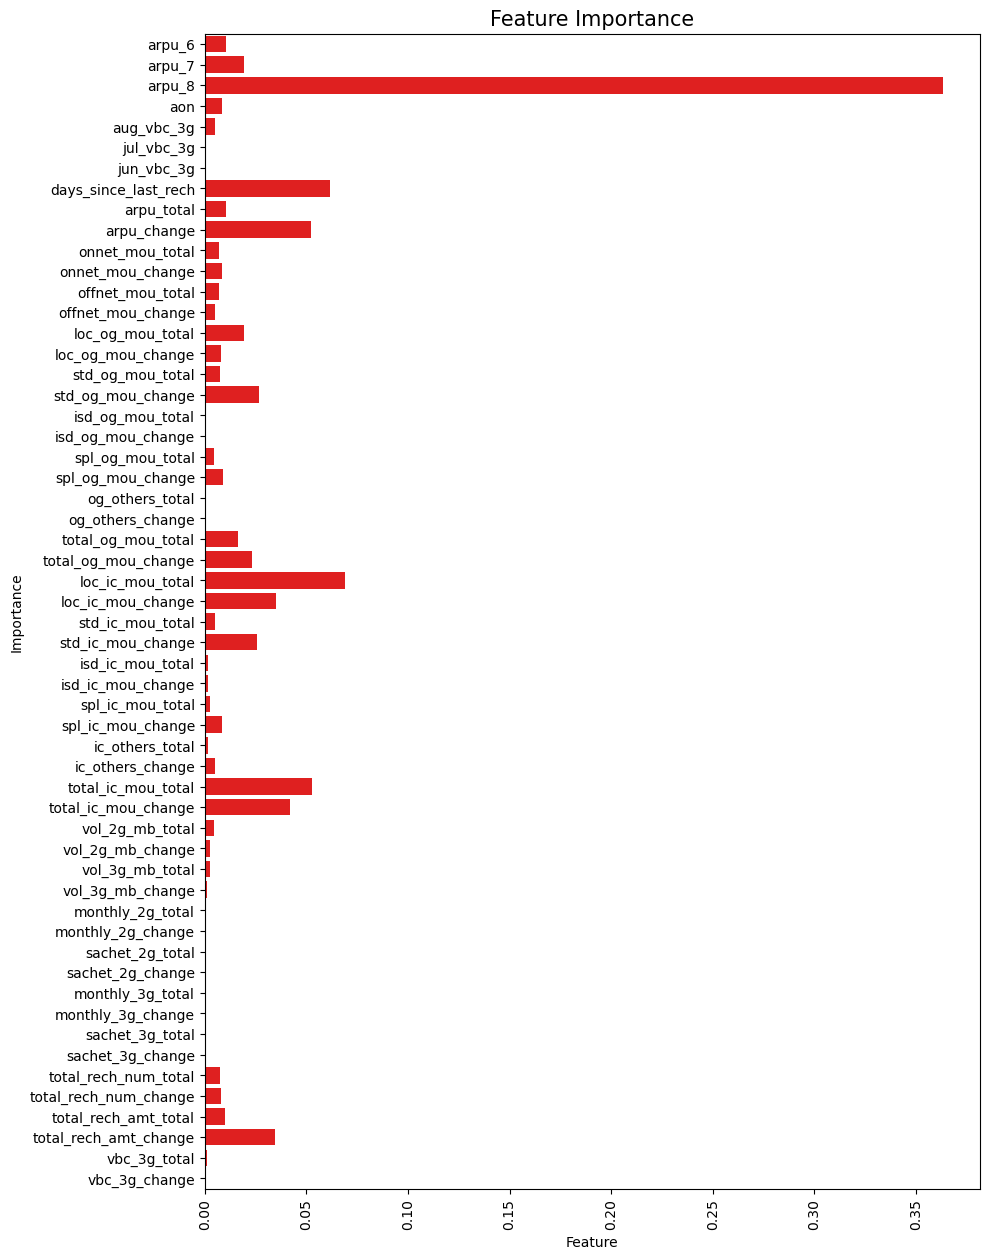

In [88]:
# Plot feature importance against the feature name to see which ones are the most important
plt.figure(figsize = (10, 15))
sns.barplot(y = X_train_data.columns, x = final_model.feature_importances_, color = random_color())
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation = 90)
plt.title("Feature Importance", fontdict={'size': 15})
plt.show()

# Test Data Analysis

In [89]:
# Fill the test data by imputing values
test_data = fill_data(test_data)
test_data

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      69999        109             0.0             0.0             0.0   
1      70000        109             0.0             0.0             0.0   
2      70001        109             0.0             0.0             0.0   
3      70002        109             0.0             0.0             0.0   
4      70003        109             0.0             0.0             0.0   
...      ...        ...             ...             ...             ...   
29995  99994        109             0.0             0.0             0.0   
29996  99995        109             0.0             0.0             0.0   
29997  99996        109             0.0             0.0             0.0   
29998  99997        109             0.0             0.0             0.0   
29999  99998        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0                6/30/2014            7/31/2014            8/31/2014   
1                6/30/2014            7/31/2014            8/31/2014   
2                6/30/2014            7/31/2014            8/31/2014   
3                6/30/2014            7/31/2014            8/31/2014   
4                6/30/2014            7/31/2014            8/31/2014   
...                    ...                  ...                  ...   
29995            6/30/2014            7/31/2014            8/31/2014   
29996            6/30/2014            7/31/2014            8/31/2014   
29997            6/30/2014            7/31/2014            8/31/2014   
29998            6/30/2014            7/31/2014            8/31/2014   
29999            6/30/2014            7/31/2014            8/31/2014   

         arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0        91.882   65.330   64.445        31.78        20.23        23.11   
1       414.168  515.568  360.868        75.51        41.21        19.84   
2       329.844  434.884  746.239         7.54         7.86         8.40   
3        43.550  171.390   24.400         5.31         2.16         0.00   
4       306.854  406.289  413.329       450.93       609.03       700.68   
...         ...      ...      ...          ...          ...          ...   
29995   718.870  396.259  406.150       324.46       250.01       285.41   
29996   218.327  324.070  374.981       263.79       467.24       650.26   
29997   139.473   38.230  180.194        11.08        14.89        19.94   
29998  1122.912  781.121  257.439       122.74        50.23        26.46   
29999   318.980  307.890  605.320        28.09        32.93        66.31   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0             60.16         32.16         34.83           0.00           0.00   
1            474.34        621.84        394.94           0.00           0.00   
2             16.98         45.81         45.04          22.81         103.38   
3             40.04        205.01         24.01           0.00           0.00   
4             60.94         23.84         74.16           0.00           0.00   
...             ...           ...           ...            ...            ...   
29995        190.36        166.14        221.96          87.76          14.78   
29996        108.53        124.11        189.76           3.40           0.00   
29997         37.24         16.74         45.28           0.00           0.00   
29998       1854.09       1088.83        306.16           0.00          21.66   
29999        107.78        241.53        331.64         134.54          67.79   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0               0.00           0.00           0.00           0.00   
1               0.00           0.00           0.00           0.00   
2              26.08          24.53          53.68          54.44   
3               0.00           0.00           0.00           0.00   
4            

In [90]:
# Create new columns and modify the values of existing ones in test data
test_data = create_and_modify_columns(test_data)
test_data

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      69999        109             0.0             0.0             0.0   
1      70000        109             0.0             0.0             0.0   
2      70001        109             0.0             0.0             0.0   
3      70002        109             0.0             0.0             0.0   
4      70003        109             0.0             0.0             0.0   
...      ...        ...             ...             ...             ...   
29995  99994        109             0.0             0.0             0.0   
29996  99995        109             0.0             0.0             0.0   
29997  99996        109             0.0             0.0             0.0   
29998  99997        109             0.0             0.0             0.0   
29999  99998        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0                6/30/2014            7/31/2014            8/31/2014   
1                6/30/2014            7/31/2014            8/31/2014   
2                6/30/2014            7/31/2014            8/31/2014   
3                6/30/2014            7/31/2014            8/31/2014   
4                6/30/2014            7/31/2014            8/31/2014   
...                    ...                  ...                  ...   
29995            6/30/2014            7/31/2014            8/31/2014   
29996            6/30/2014            7/31/2014            8/31/2014   
29997            6/30/2014            7/31/2014            8/31/2014   
29998            6/30/2014            7/31/2014            8/31/2014   
29999            6/30/2014            7/31/2014            8/31/2014   

         arpu_6   arpu_7   arpu_8  roam_ic_mou_6  roam_ic_mou_7  \
0        91.882   65.330   64.445           0.00           0.00   
1       414.168  515.568  360.868           0.00           0.00   
2       329.844  434.884  746.239          22.81         103.38   
3        43.550  171.390   24.400           0.00           0.00   
4       306.854  406.289  413.329           0.00           0.00   
...         ...      ...      ...            ...            ...   
29995   718.870  396.259  406.150          87.76          14.78   
29996   218.327  324.070  374.981           3.40           0.00   
29997   139.473   38.230  180.194           0.00           0.00   
29998  1122.912  781.121  257.439           0.00          21.66   
29999   318.980  307.890  605.320         134.54          67.79   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0               0.00           0.00           0.00           0.00   
1               0.00           0.00           0.00           0.00   
2              26.08          24.53          53.68          54.44   
3               0.00           0.00           0.00           0.00   
4               0.00           0.00           0.00           0.00   
...              ...            ...            ...            ...   
29995           0.00         112.43           8.46           0.00   
29996           0.00           8.29           0.00           0.00   
29997          24.59           0.00           0.00          15.58   
29998           0.00           0.00          26.94           0.00   
29999         141.78         129.83          81.74         179.84   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0                 24.88             20.23             21.06             18.13   
1                 75.51             41.21             19.84            473.61   
2                  0.00              0.00              0.00              0.00   
3                  5.31              0.00              0.00              2.94   
4                  0.45              0.78             14.56              2.39   
...                 ...               ...               ...               ...   
29995            214.99            233.96  

In [91]:
# Create test data as per the final training data columns
X_test_data = test_data.loc[:, final_train_data.columns]

# # Print top 5 records from feature testing set
X_test_data.head()

arpu_6   arpu_7   arpu_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0   91.882   65.330   64.445  1692        0.00        0.00        0.00   
1  414.168  515.568  360.868  2533        0.00        0.00        0.00   
2  329.844  434.884  746.239   277      525.61      758.41      241.84   
3   43.550  171.390   24.400  1244        0.00        0.00        0.00   
4  306.854  406.289  413.329   462        0.00        0.00        0.00   

   days_since_last_rech  arpu_total  arpu_change  onnet_mou_total  \
0                     7     221.657     -13.7185            75.12   
1                     7    1290.604     -26.6500           136.56   
2                     3    1510.967     208.1975            23.80   
3                     7     239.340      -9.5750             7.47   
4                     1    1126.472      53.2375          1760.64   

   onnet_mou_change  offnet_mou_total  offnet_mou_change  loc_og_mou_total  \
0            -4.335            127.15            -12.665            117.15   
1           -27.835           1491.12            -39.700           1586.26   
2             0.430            107.83             14.030              0.00   
3            -2.655            269.06             -8.015            129.73   
4           124.875            158.94              6.610             31.79   

   loc_og_mou_change  std_og_mou_total  std_og_mou_change  isd_og_mou_total  \
0             -6.790             85.09            -10.225               0.0   
1            -76.375             41.44              8.840               0.8   
2              0.000              0.00              0.000               0.0   
3              7.300            133.62            -18.545               0.0   
4             11.335           1887.75            120.130               0.0   

   isd_og_mou_change  spl_og_mou_total  spl_og_mou_change  og_others_total  \
0                0.0              0.03              0.015              0.0   
1                0.4              0.00              0.000              0.0   
2                0.0              0.00              0.000              0.0   
3                0.0             13.18              0.575              0.0   
4                0.0             11.06              2.125              2.2   

   og_others_change  total_og_mou_total  total_og_mou_change  \
0               0.0              202.27              -17.000   
1               0.0             1628.51              -67.135   
2               0.0                0.00                0.000   
3               0.0              276.55              -10.675   
4              -1.1             1932.85              132.495   

   loc_ic_mou_total  loc_ic_mou_change  std_ic_mou_total  std_ic_mou_change  \
0            114.48              -4.65              5.74              1.990   
1            518.36               2.87             12.51              0.000   
2              0.00               0.00              0.00              0.000   
3           1582.56              -7.21             34.60             -0.400   
4             37.33               3.74            291.40             48.945   

   isd_ic_mou_total  isd_ic_mou_change  spl_ic_mou_total  spl_ic_mou_change  \
0              0.00              0.000              1.27             -0.075   
1            386.74            -10.200              0.00              0.000   
2              0.00              0.000              0.00              0.000   
3             10.08              4.325              0.00              0.000   
4              0.00              0.000              0.00              0.000   

   ic_others_total  ic_others_change  total_ic_mou_total  total_ic_mou_change  \
0             0.00              0.00              121.55               -2.735   
1             0.00              0.00              917.63               -7.335   
2             0.00              0.00                0.00                0.000   
3             0.00              0.00             1627.26               -

In [92]:
# Scale test data using earlier fitted scaler
X_test_data[X_test_data.columns] = scaler.transform(X_test_data[X_test_data.columns])

# Print first 5 rows of training set
X_test_data.head()

arpu_6    arpu_7    arpu_8       aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0 -0.706660 -0.816392 -0.805401  0.617396   -0.262863   -0.248431   -0.234794   
1  0.715986  1.233152  0.509930  1.579283   -0.262863   -0.248431   -0.234794   
2  0.343760  0.865867  2.219953 -1.001000    2.074972    3.068273    0.874312   
3 -0.920009 -0.333592 -0.983094  0.104999   -0.262863   -0.248431   -0.234794   
4  0.242276  0.735699  0.742717 -0.789407   -0.262863   -0.248431   -0.234794   

   days_since_last_rech  arpu_total  arpu_change  onnet_mou_total  \
0              0.013718   -0.931778    -0.087610        -0.409809   
1              0.013718    0.980211    -0.193399        -0.315804   
2             -0.395063    1.374366     1.727831        -0.488331   
3              0.013718   -0.900149    -0.053713        -0.513317   
4             -0.599454    0.686633     0.460141         2.169109   

   onnet_mou_change  offnet_mou_total  offnet_mou_change  loc_og_mou_total  \
0         -0.017796         -0.584594          -0.074328         -0.442402   
1         -0.209234          1.536878          -0.281870          2.142747   
2          0.021022         -0.614644           0.130605         -0.648547   
3         -0.004110         -0.363872          -0.038630         -0.420265   
4          1.034788         -0.535149           0.073643         -0.592608   

   loc_og_mou_change  std_og_mou_total  std_og_mou_change  isd_og_mou_total  \
0          -0.043872         -0.430645          -0.061236         -0.067867   
1          -0.882872         -0.483562           0.052803         -0.011701   
2           0.037996         -0.533800          -0.000074         -0.067867   
3           0.126014         -0.371811          -0.111002         -0.067867   
4           0.174665          1.754737           0.718491         -0.067867   

   isd_og_mou_change  spl_og_mou_total  spl_og_mou_change  og_others_total  \
0           0.004865         -0.298426          -0.057885        -0.103131   
1           0.131145         -0.299111          -0.059628        -0.103131   
2           0.004865         -0.299111          -0.059628        -0.103131   
3           0.004865          0.001946           0.007191        -0.103131   
4           0.004865         -0.046479           0.187313         0.371432   

   og_others_change  total_og_mou_total  total_og_mou_change  \
0          0.093664           -0.633822            -0.070852   
1          0.093664            0.821474            -0.321694   
2          0.093664           -0.840213             0.014205   
3          0.093664           -0.558029            -0.039206   
4         -0.427873            1.132014             0.677122   

   loc_ic_mou_total  loc_ic_mou_change  std_ic_mou_total  std_ic_mou_change  \
0         -0.513578          -0.034641         -0.306678           0.042642   
1          0.084551           0.044590         -0.282191           0.000133   
2         -0.683118           0.014351         -0.327441           0.000133   
3          1.660585          -0.061614         -0.202288          -0.008412   
4         -0.627834           0.053756          0.726588           1.045664   

   isd_ic_mou_total  isd_ic_mou_change  spl_ic_mou_total  spl_ic_mou_change  \
0         -0.136288          -0.016305          3.622655          -0.637484   
1          2.326858          -0.448922         -0.429481           0.105532   
2         -0.136288          -0.016305         -0.429481           0.105532   
3         -0.072088           0.167133         -0.429481           0.105532   
4         -0.136288          -0.016305         -0.429481           0.105532   

   ic_others_total  ic_others_change  total_ic_mou_total  total_ic_mou_change  \
0        -0.089857         -0.009725           -0.582696            -0.015793   
1        -0.089857         -0.009725            0.438356            -0.056250   
2        -0.089857         -0.009725           -0.738596             0.008260   
3        -0.089857         -0.0

In [93]:
# If PCA is set to true, transform data to pca components and prepare X_test_data
if isPCA == True:
    pca_test_components = pca.transform(X_test_data)
    X_test_data = pca_test_components[:, :selected_components]

In [94]:
# Prepare dataframe containing churn prediction obtained from the model for test data
y_test_data_pred = final_model.predict(X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn_probability': y_test_data_pred, 'id': test_data.id })
y_test_data_pred

churn_probability     id
0                      0  69999
1                      0  70000
2                      0  70001
3                      0  70002
4                      0  70003
...                  ...    ...
29995                  0  99994
29996                  0  99995
29997                  0  99996
29998                  0  99997
29999                  0  99998

[30000 rows x 2 columns]

In [95]:
# Output the final churn probability against id into a file for upload
output = y_test_data_pred[['id', 'churn_probability']]
output.to_csv('results/submission.csv', index = False)
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

### Best Scores

**Random Forest (Rank 1)**

Score = **0.94436**

Parameters = 
```json
{
    'max_depth': 12, 
    'max_features': 10, 
    'min_samples_leaf': 25, 
    'n_estimators': 100
}
```

**XGB (Rank 2)**

Score = **0.94436**

Parameters = 
```json
{
    'n_estimators': 50,    
    'min_child_weight': 1, 
    'max_depth': 7, 
    'learning_rate': 0.1, 
    'gamma': 0.25
}
```